In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser

In [2]:
start_day_to_analyze = '2020-02-21'
end_day_to_analyze = '2020-02-22'

In [3]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [4]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [5]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [6]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty'] 
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')

,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,69,algo.py,PAPER,v0.1-128-g4164164,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-02-21 14:45:16.217751,2020-02-21 21:10:00.967927,market close


,symbol,count,revenue,%
0,CENX,9,-75.20,-3.01
1,CYH,8,9.95,0.32
2,VXX,7,-3.81,-0.20
3,VTVT,7,-22.29,-2.15
4,TRIL,6,-16.90,-0.91
5,FNGD,5,0.32,0.00
6,KGC,5,-33.07,-0.51
7,MIK,4,-62.51,-2.67
8,EGO,4,2.21,0.11
9,VIXY,4,5.68,0.08


TOTAL REVENUE: -540.5 $


In [11]:
minute_history = {}
for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

nan
nan
all


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
0,CENX,69,False,4.376013,True,0.02,0.02
65,PLG,69,False,0.735075,False,0.02,0.01
64,PLG,69,False,3.041985,False,0.02,0.01
63,PLG,69,False,3.041985,False,0.02,0.01
62,AUY,69,False,-0.213675,False,0.00,0.00
61,AUY,69,False,-0.213675,False,0.00,0.00
60,AUY,69,False,-0.213675,False,0.00,0.00
59,AUY,69,False,-0.213675,False,0.00,0.00
58,VIXY,69,False,0.081037,False,0.03,0.02
55,VIXY,69,False,0.570033,False,0.03,0.02


winners analysis


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
0,CENX,69,False,4.376013,True,0.02,0.02
76,SOXS,69,False,0.765027,False,0.04,0.02
29,VTVT,69,False,1.623053,True,0.03,0.03
30,VTVT,69,False,0.064417,False,0.03,0.03
31,TRIL,69,False,2.777778,True,0.02,0.02
32,TRIL,69,False,2.068966,True,0.02,0.02
75,AVEO,69,False,0.377358,True,0.02,0.02
34,TRIL,69,False,1.369863,True,0.02,0.02
35,TRIL,69,False,0.225734,False,0.02,0.02
36,TRIL,69,False,0.452489,True,0.02,0.02


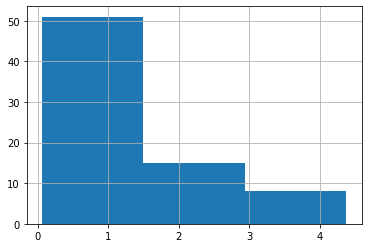

In [12]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []
symbols = []
r_ids = []
scalp = []

for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            if min_time is None or max_time is None:
                continue
             
            try:
                max_val = minute_history[symbol]['close'][min_time:max_time].max()
            except Exception:
                continue
                
            if math.isnan(max_val):
                continue
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            
            if math.isnan(macd_val):
                print(macds[0][-5])
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            symbols.append(symbol)
            r_ids.append(run_id)
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'symobl':symbols,
    'run': r_ids,
    'win': win,
    'max_val %': slopes,
    'bail_outs': bail_outs,
    'macd': macd,
    'macd_signal': macd_signal,
}
slope_analysis = pd.DataFrame(data=d)
print("all")
display(HTML(slope_analysis.sort_values(by=['win']).to_html()))
print("winners analysis")
display(HTML(slope_analysis.loc[slope_analysis['max_val %'] > 0].sort_values(by=['win']).to_html()))
slope_analysis.loc[slope_analysis['max_val %'] > 0.003]['max_val %'].hist(bins=3)


In [13]:

parser.isoparse('2020-02-21T15:10:08.568616385Z')

datetime.datetime(2020, 2, 21, 15, 10, 8, 568616, tzinfo=tzutc())

CENX analysis for run 69
2020-02-21T15:10:08.568616385Z 6.17
2020-02-21T15:10:42.228256232Z 6.17
2020-02-21T15:11:06.03645369Z 6.18
2020-02-21T15:26:05.93104478Z 6.31
2020-02-21T15:29:00.720284134Z 6.31
2020-02-21T15:36:32.996232988Z 6.34
2020-02-21T15:58:01.925565676Z 6.41
2020-02-21T15:59:22.456154509Z 6.42
2020-02-21T15:59:24.64107632Z 6.42


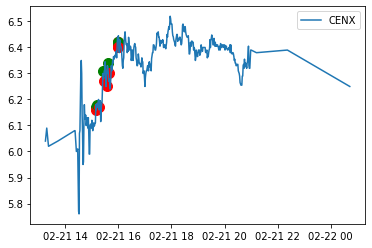

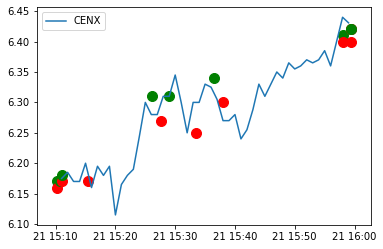

Delta = -0.18999999999999861


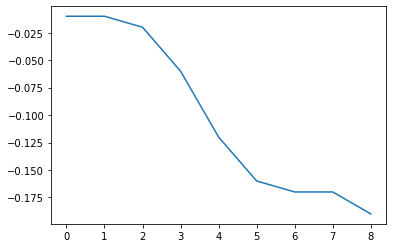

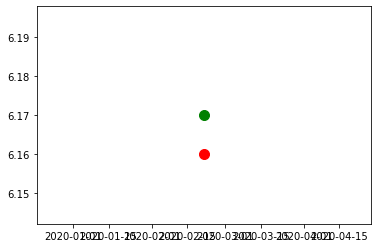

buy time:2020-02-21T15:10:08.568616385Z sell time:2020-02-21T15:10:12.530989224Z
{'rsi': 58.84441911019383, 'macd1': [0.01824705942941307, 0.018051409270449348, 0.01769240804310801, 0.022793561975611887, 0.026131576458620742], 'macd2': [0.04031649918217983, 0.040000693216102334, 0.03964616610662297, 0.04037613350232938, 0.040903182859990395], 'macd_signal': [0.023044652581064466, 0.022046003918941442, 0.021175284743774756, 0.02149894019014218, 0.022425467443837895]}
{'rsi': 57.49377332605381, 'macd': [0.008772553150414808, 0.008760845011263285, 0.008637944578011592, 0.012066360544594978, 0.013801926745249382], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016194331983805323, 'too_close': 0, 'macd_signal': [0.011472963732039564, 0.010930539987884309, 0.010472020905909766, 0.010790888833646808, 0.011393096415967323], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002408830329282059}


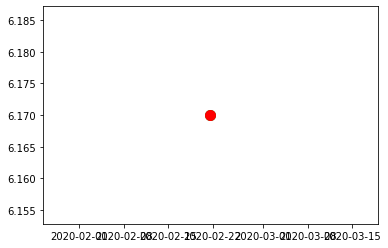

buy time:2020-02-21T15:10:42.228256232Z sell time:2020-02-21T15:11:03.362160961Z
{'rsi': 58.16125595519721, 'macd1': [0.01824705942941307, 0.018051409270449348, 0.01769240804310801, 0.022793561975611887, 0.025732716059760463], 'macd2': [0.04031649918217983, 0.040000693216102334, 0.03964616610662297, 0.04037613350232938, 0.040823214847195644], 'macd_signal': [0.023044652581064466, 0.022046003918941442, 0.021175284743774756, 0.02149894019014218, 0.02234569536406584]}
{'rsi': 58.16125595519721, 'macd': [0.008772553150414808, 0.008760845011263285, 0.008637944578011592, 0.012066360544594978, 0.014061667004989786], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.011472963732039564, 0.010930539987884309, 0.010472020905909766, 0.010790888833646808, 0.011445044467915404], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0026166225370743822}


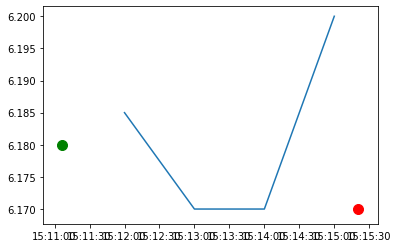

buy time:2020-02-21T15:11:06.03645369Z sell time:2020-02-21T15:15:20.347908208Z
{'rsi': 58.85255734106168, 'macd1': [0.018051409270449348, 0.01769240804310801, 0.022793561975611887, 0.024934995262039017, 0.02792403848915992], 'macd2': [0.040000693216102334, 0.03964616610662297, 0.04037613350232938, 0.04066327882160614, 0.04118229851947497], 'macd_signal': [0.022046003918941442, 0.021175284743774756, 0.02149894019014218, 0.022186151204521547, 0.02333372866144922]}
{'rsi': 57.11405749333052, 'macd': [0.015295528952642634, 0.016982607122452364, 0.017297439370064893, 0.017318121129632935, 0.017109326122417556], 'scalp': 0, 'bail_out': 0, 'movement': -0.001618122977346244, 'too_close': 0, 'macd_signal': [0.01213202448174392, 0.013102141009885609, 0.013941200681921466, 0.01461658477146376, 0.01511513304165452], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001994193080763037}


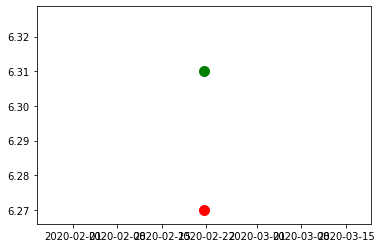

buy time:2020-02-21T15:26:05.93104478Z sell time:2020-02-21T15:27:41.661856058Z
{'rsi': 66.85910210004845, 'macd1': [0.022544540531463042, 0.022930915028315013, 0.02727202422068231, 0.03483759952272969, 0.04116575567649594], 'macd2': [0.04041799896384113, 0.04031764198003973, 0.04102288308853819, 0.04250335820181217, 0.04395740050602548], 'macd_signal': [0.026408073342150524, 0.025712641679383422, 0.0260245181876432, 0.0277871344546605, 0.030462858699027588]}
{'rsi': 61.55887484437377, 'macd': [0.012587296355343724, 0.015447560324666654, 0.020390005491350394, 0.022937495160307186, 0.024105181978192114], 'scalp': 0, 'bail_out': 0, 'movement': -0.004761904761904801, 'too_close': 0, 'macd_signal': [0.01428143873565703, 0.014514663053458955, 0.01568973154103724, 0.01713928426489123, 0.018532463807551407], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005572718170640707}


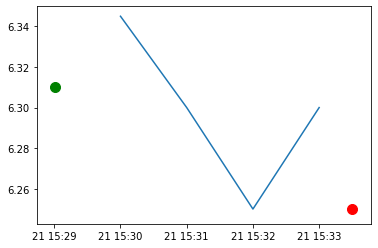

buy time:2020-02-21T15:29:00.720284134Z sell time:2020-02-21T15:33:29.548096518Z
{'rsi': 65.77307211915763, 'macd1': [0.02727202422068231, 0.03483759952272969, 0.03877259328333338, 0.04141371268798455, 0.045404177034216175], 'macd2': [0.04102288308853819, 0.04250335820181217, 0.043477592429256084, 0.04430438274818105, 0.04547400569614268], 'macd_signal': [0.0260245181876432, 0.0277871344546605, 0.029984226220395073, 0.032270123513912966, 0.03489693421797361]}
{'rsi': 54.03354909617861, 'macd': [0.028814615670365917, 0.03153388293070769, 0.030905599199406275, 0.027417253445153555, 0.024342993721772288], 'scalp': 0, 'bail_out': 0, 'movement': -0.006359300476947541, 'too_close': 1, 'macd_signal': [0.022038670132080322, 0.023937712691805797, 0.025331289993325894, 0.025748482683691426, 0.0254673848913076], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0011243911695353118}


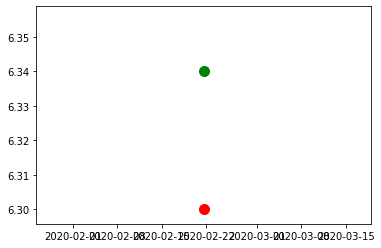

buy time:2020-02-21T15:36:32.996232988Z sell time:2020-02-21T15:37:55.900473345Z
{'rsi': 63.102227232533195, 'macd1': [0.04625467336141931, 0.04562486330065507, 0.04461148090774092, 0.0457022897918371, 0.04683380911935586], 'macd2': [0.04796816749817445, 0.048307114282204466, 0.048541695686812325, 0.04915969050058955, 0.049809577467602395], 'macd_signal': [0.04339220730551442, 0.04383873850454255, 0.04399328698518222, 0.0443350875465132, 0.04483483186108173]}
{'rsi': 58.13403572592024, 'macd': [0.026940396319174553, 0.026218944061020544, 0.026874709261666574, 0.026776932674355436, 0.02531402971444674], 'scalp': 0, 'bail_out': 0, 'movement': -0.003949447077409219, 'too_close': 1, 'macd_signal': [0.02598686541078805, 0.02603328114083455, 0.026201566765000954, 0.02631663994687185, 0.02611611790038683], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0008020881859400891}


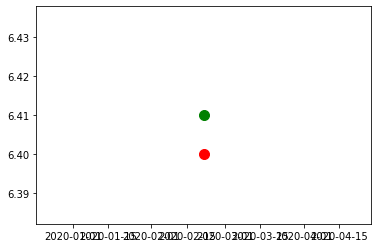

buy time:2020-02-21T15:58:01.925565676Z sell time:2020-02-21T15:58:04.604407667Z
{'rsi': 65.47056142425458, 'macd1': [0.033101127456343526, 0.03387590309226329, 0.032102568868642045, 0.033538246398641114, 0.03507858353583515], 'macd2': [0.04629581149460105, 0.04648065732536999, 0.04617654202241095, 0.04646263739218348, 0.046811479813726464], 'macd_signal': [0.031511830896862984, 0.03198464533594304, 0.03200823004248284, 0.0323142333137145, 0.032867103358138625]}
{'rsi': 64.83794016352573, 'macd': [0.0189653119791231, 0.019471897270455507, 0.018315055974475136, 0.01925368540650929, 0.019994777361256766], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007800312012480333, 'too_close': 0, 'macd_signal': [0.017863877450757317, 0.018185481414696954, 0.01821139632665259, 0.018419854142623933, 0.0187348387863505], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001259938574906267}


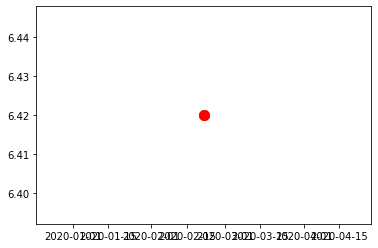

buy time:2020-02-21T15:59:22.456154509Z sell time:2020-02-21T15:59:23.377893529Z
{'rsi': 66.66988476417195, 'macd1': [0.033101127456343526, 0.03387590309226329, 0.032102568868642045, 0.033538246398641114, 0.0358763043335566], 'macd2': [0.04629581149460105, 0.04648065732536999, 0.04617654202241095, 0.04646263739218348, 0.046971415839315966], 'macd_signal': [0.031511830896862984, 0.03198464533594304, 0.03200823004248284, 0.0323142333137145, 0.03302664751768292]}
{'rsi': 64.33455775471842, 'macd': [0.019471897270455507, 0.018315055974475136, 0.01925368540650929, 0.021812959179438707, 0.02248495225991043], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.018185481414696954, 0.01821139632665259, 0.018419854142623933, 0.019098475149986888, 0.019775770571971597], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0027091816879388324}


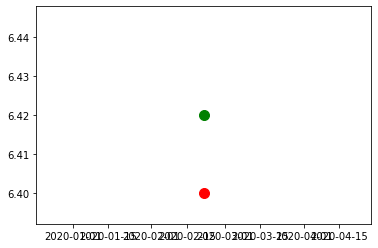

buy time:2020-02-21T15:59:24.64107632Z sell time:2020-02-21T15:59:26.257997619Z
{'rsi': 64.33455775471842, 'macd1': [0.03387590309226329, 0.032102568868642045, 0.033538246398641114, 0.03747174592899771, 0.03853107751626883], 'macd2': [0.04648065732536999, 0.04617654202241095, 0.04646263739218348, 0.04729128789049497, 0.0476581649976735], 'macd_signal': [0.03198464533594304, 0.03200823004248284, 0.0323142333137145, 0.03334573583677114, 0.03438280417267068]}
{'rsi': 60.38661407361905, 'macd': [0.019471897270455507, 0.018315055974475136, 0.01925368540650929, 0.021812959179438707, 0.021445991220948812], 'scalp': 0, 'bail_out': 0, 'movement': -0.0031152647975077217, 'too_close': 0, 'macd_signal': [0.018185481414696954, 0.01821139632665259, 0.018419854142623933, 0.019098475149986888, 0.019567978364179273], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001878012856769539}
CYH analysis for run 6

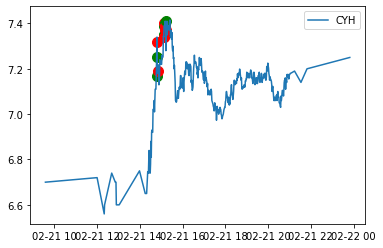

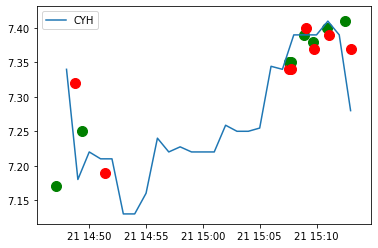

Delta = 0.02000000000000135


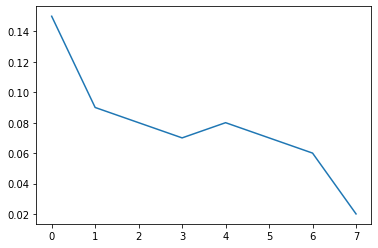

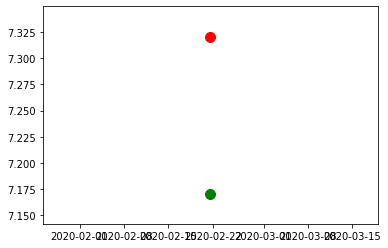

buy time:2020-02-21T14:47:06.917838882Z sell time:2020-02-21T14:48:43.761008936Z
{'rsi': 71.74880348178043, 'macd1': [0.04694256248218309, 0.05283021718669101, 0.05684099831202616, 0.06412191231834807, 0.06909559808035759], 'macd2': [-0.00658752926258277, -0.003699495858042745, -0.0010364959191067058, 0.002374823090556255, 0.00550954750034105], 'macd_signal': [0.017683649723741153, 0.024712963216331124, 0.03113857023547013, 0.03773523865204572, 0.044007310537708094]}
{'rsi': 78.21307957014885, 'macd': [0.03588797610701899, 0.03814276156249008, 0.04252125981918908, 0.04953669664493887, 0.05799630070857642], 'scalp': 1, 'bail_out': 0, 'movement': 0.02092050209205026, 'too_close': 0, 'macd_signal': [0.01848250021938343, 0.02241455248800476, 0.026435893954241625, 0.031056054492381073, 0.03644410373562014], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.02155219697295628}


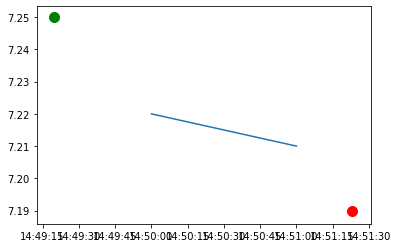

buy time:2020-02-21T14:49:19.792453247Z sell time:2020-02-21T14:51:23.051643473Z
{'rsi': 72.85306506954218, 'macd1': [0.05684099831202616, 0.06412191231834807, 0.07547736446212383, 0.09069343250112638, 0.09759270595047376], 'macd2': [-0.0010364959191067058, 0.002374823090556255, 0.006789035705059732, 0.012278818625152788, 0.01651027613200373], 'macd_signal': [0.03113857023547013, 0.03773523865204572, 0.04528366381406134, 0.05436561755147435, 0.06301103523127423]}
{'rsi': 60.96621792875685, 'macd': [0.04953669664493887, 0.05903526174753715, 0.05735836102556835, 0.057384693436688394, 0.054639177218902546], 'scalp': 0, 'bail_out': 0, 'movement': -0.014938271604938302, 'too_close': 0, 'macd_signal': [0.031056054492381073, 0.03665189594341229, 0.040793188959843504, 0.04411148985521248, 0.046217027327950494], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008422149890952052}


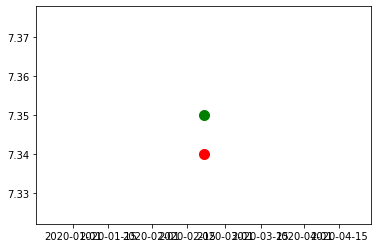

buy time:2020-02-21T15:07:33.426995038Z sell time:2020-02-21T15:07:36.007928089Z
{'rsi': 71.20497226738668, 'macd1': [0.058402088180346645, 0.05696836884285528, 0.055570801056012975, 0.060998110612692, 0.06553633763729572], 'macd2': [0.03636760533994465, 0.03739021344011029, 0.03834641511332926, 0.0405994476561613, 0.042804097832264354], 'macd_signal': [0.06285012289141573, 0.06167377208170364, 0.060453177876565505, 0.0605621644237908, 0.061556999066491785]}
{'rsi': 70.10381726977565, 'macd': [0.034056142331695405, 0.03304359074360974, 0.03206960780817081, 0.03555391191291779, 0.037718903268396886], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019030271725094452, 'too_close': 0, 'macd_signal': [0.037642763430855854, 0.03672292889340663, 0.035792264676359466, 0.03574459412367113, 0.036139455952616285], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0015794473157806008}


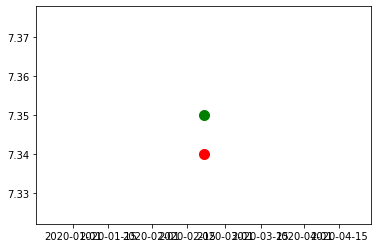

buy time:2020-02-21T15:07:44.097758829Z sell time:2020-02-21T15:07:45.834902524Z
{'rsi': 71.41828233697716, 'macd1': [0.058402088180346645, 0.05696836884285528, 0.055570801056012975, 0.060998110612692, 0.06579958550054421], 'macd2': [0.03636760533994465, 0.03739021344011029, 0.03834641511332926, 0.0405994476561613, 0.04285687672070804], 'macd_signal': [0.06285012289141573, 0.06167377208170364, 0.060453177876565505, 0.0605621644237908, 0.061609648639141486]}
{'rsi': 70.42233811715963, 'macd': [0.034056142331695405, 0.03304359074360974, 0.03206960780817081, 0.03555391191291779, 0.03783838378787774], 'scalp': 0, 'bail_out': 0, 'movement': -0.0020380434782609467, 'too_close': 0, 'macd_signal': [0.037642763430855854, 0.03672292889340663, 0.035792264676359466, 0.03574459412367113, 0.03616335205651246], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0016750317313652813}


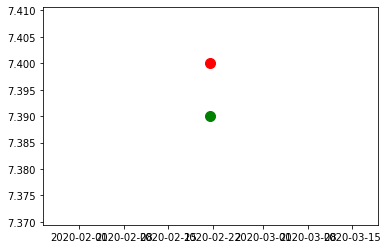

buy time:2020-02-21T15:08:55.802130325Z sell time:2020-02-21T15:09:01.922277706Z
{'rsi': 73.01400431463397, 'macd1': [0.05696836884285528, 0.055570801056012975, 0.060998110612692, 0.0642041439051022, 0.06997292618371276], 'macd2': [0.03739021344011029, 0.03834641511332926, 0.0405994476561613, 0.04253700466952903, 0.04505126723213593], 'macd_signal': [0.06167377208170364, 0.060453177876565505, 0.0605621644237908, 0.06129056032005308, 0.06302703349278502]}
{'rsi': 73.00804914279985, 'macd': [0.03304359074360974, 0.03206960780817081, 0.03555391191291779, 0.037578643528137334, 0.0412605299357347], 'scalp': 0, 'bail_out': 0, 'movement': -1.353179972933247e-05, 'too_close': 0, 'macd_signal': [0.03672292889340663, 0.035792264676359466, 0.03574459412367113, 0.036111404004564376, 0.037141229190798444], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004119300744936258}


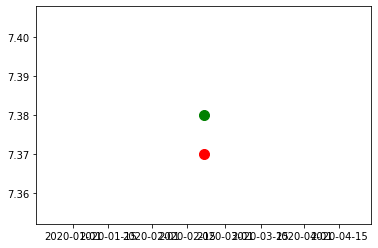

buy time:2020-02-21T15:09:42.671943226Z sell time:2020-02-21T15:09:44.969127704Z
{'rsi': 74.15025134026666, 'macd1': [0.055570801056012975, 0.060998110612692, 0.0642041439051022, 0.06997292618371276, 0.07517099861073007], 'macd2': [0.03834641511332926, 0.0405994476561613, 0.04253700466952903, 0.04505126723213593, 0.04758829765501904], 'macd_signal': [0.060453177876565505, 0.0605621644237908, 0.06129056032005308, 0.06302703349278502, 0.06545582651637402]}
{'rsi': 69.70178851904598, 'macd': [0.03206960780817081, 0.03555391191291779, 0.037578643528137334, 0.04126572474093049, 0.04256389549452333], 'scalp': 0, 'bail_out': 0, 'movement': -0.0051967334818114296, 'too_close': 0, 'macd_signal': [0.035792264676359466, 0.03574459412367113, 0.036111404004564376, 0.0371422681518376, 0.03822659362037474], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004337301874148589}


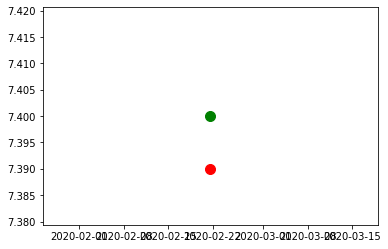

buy time:2020-02-21T15:10:54.650413621Z sell time:2020-02-21T15:11:06.043299467Z
{'rsi': 73.68728333042061, 'macd1': [0.060998110612692, 0.0642041439051022, 0.06997292618371276, 0.07369521513494703, 0.07656942767355002], 'macd2': [0.0405994476561613, 0.04253700466952903, 0.04505126723213593, 0.04729241600767775, 0.04943864298428391], 'macd_signal': [0.0605621644237908, 0.06129056032005308, 0.06302703349278502, 0.06516066982121742, 0.06744242139168394]}
{'rsi': 73.01400431463398, 'macd': [0.03555391191291779, 0.037578643528137334, 0.04126572474093049, 0.04360285653348406, 0.04485772732594828], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013513513513514425, 'too_close': 0, 'macd_signal': [0.03574459412367113, 0.036111404004564376, 0.0371422681518376, 0.03843438582816689, 0.03971905412772317], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005138673198225113}


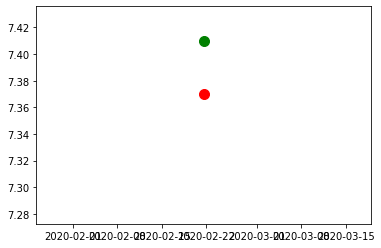

buy time:2020-02-21T15:12:29.376943648Z sell time:2020-02-21T15:13:03.44010665Z
{'rsi': 74.42356592348528, 'macd1': [0.06997292618371276, 0.07369521513494703, 0.07577170687582857, 0.07813053422978644, 0.07908824188055341], 'macd2': [0.04505126723213593, 0.04729241600767775, 0.04927870695869352, 0.05134721581533164, 0.05316818743303031], 'macd_signal': [0.06302703349278502, 0.06516066982121742, 0.06728287723213965, 0.069452408631669, 0.07137957528144588]}
{'rsi': 67.55433620207867, 'macd': [0.04360285653348406, 0.04485772732594828, 0.046291941874285314, 0.045769356562932906, 0.04398851922210145], 'scalp': 0, 'bail_out': 0, 'movement': -0.004723346828610006, 'too_close': 0, 'macd_signal': [0.03843438582816689, 0.03971905412772317, 0.041033631677035595, 0.041980776654215055, 0.042382325167792334], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001606194054309118}
VXX analysis for run 69
2020

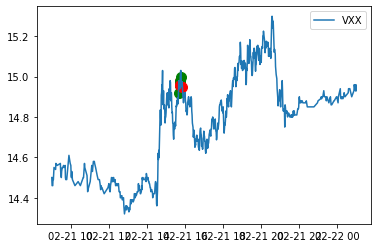

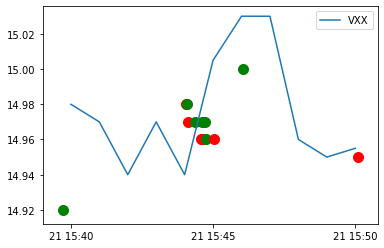

Delta = -0.02999999999999936


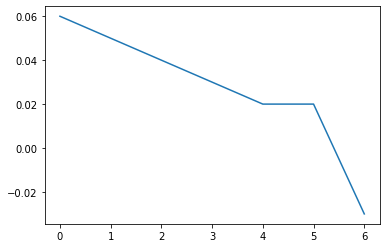

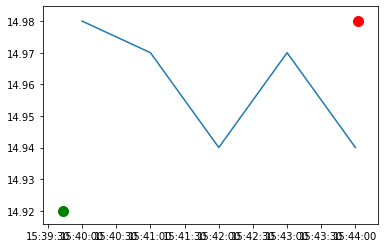

buy time:2020-02-21T15:39:42.782971017Z sell time:2020-02-21T15:44:01.841779759Z
{'rsi': 60.28296286538745, 'macd1': [0.003758715895266107, 0.009498603595710975, 0.013089699616335437, 0.014158624423192379, 0.019222213665907262], 'macd2': [0.05597298185034916, 0.05574264270125617, 0.0552816347233005, 0.054449205336586814, 0.054475907919483646], 'macd_signal': [-0.007784566955562313, -0.004327932845307655, -0.000844406352979036, 0.002156199802255247, 0.0055694025749856504]}
{'rsi': 62.39004689857106, 'macd': [0.01673333940681232, 0.020428770627601622, 0.02148457715512997, 0.02358670461612533, 0.024918405175132108], 'scalp': 0, 'bail_out': 1, 'movement': 0.0033512064343164017, 'too_close': 0, 'macd_signal': [0.004927195975854214, 0.008027510906203695, 0.01071892415598895, 0.013292480248016226, 0.015617665233439403], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009300739941692705}


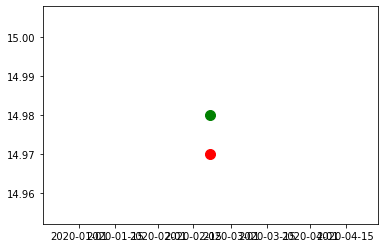

buy time:2020-02-21T15:44:04.011429168Z sell time:2020-02-21T15:44:06.629037341Z
{'rsi': 63.29238654895145, 'macd1': [0.02714077734368736, 0.032862757746501714, 0.03457812407068417, 0.037921181742669674, 0.04090595704986555], 'macd2': [0.055226074237269884, 0.05581513509099345, 0.055788013333318176, 0.056153643394196706, 0.056560160865810616], 'macd_signal': [0.009756042201090703, 0.014377385310172904, 0.018417533062275157, 0.022318262798354062, 0.02603580164865636]}
{'rsi': 62.39004689857106, 'macd': [0.01673333940681232, 0.020428770627601622, 0.02148457715512997, 0.02358670461612533, 0.024918405175132108], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006675567423230832, 'too_close': 0, 'macd_signal': [0.004927195975854214, 0.008027510906203695, 0.01071892415598895, 0.013292480248016226, 0.015617665233439403], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009300739941692705}


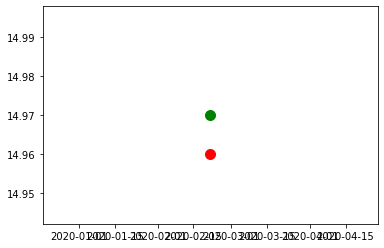

buy time:2020-02-21T15:44:21.061288276Z sell time:2020-02-21T15:44:34.163595603Z
{'rsi': 62.846694680605154, 'macd1': [0.02714077734368736, 0.032862757746501714, 0.03457812407068417, 0.037921181742669674, 0.04050709665100527], 'macd2': [0.055226074237269884, 0.05581513509099345, 0.055788013333318176, 0.056153643394196706, 0.056480192853015865], 'macd_signal': [0.009756042201090703, 0.014377385310172904, 0.018417533062275157, 0.022318262798354062, 0.025956029568884303]}
{'rsi': 60.89318214700258, 'macd': [0.01673333940681232, 0.020428770627601622, 0.02148457715512997, 0.02358670461612533, 0.024398924655653076], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010016694490817223, 'too_close': 0, 'macd_signal': [0.004927195975854214, 0.008027510906203695, 0.01071892415598895, 0.013292480248016226, 0.015513769129543597], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00888515552610948}


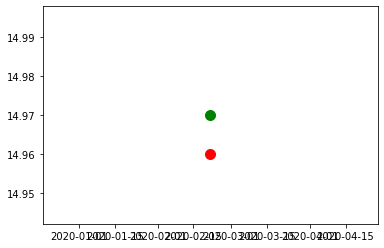

buy time:2020-02-21T15:44:35.73131406Z sell time:2020-02-21T15:44:36.436548702Z
{'rsi': 62.39004689857106, 'macd1': [0.02714077734368736, 0.032862757746501714, 0.03457812407068417, 0.037921181742669674, 0.04010823625214499], 'macd2': [0.055226074237269884, 0.05581513509099345, 0.055788013333318176, 0.056153643394196706, 0.05640022484021934], 'macd_signal': [0.009756042201090703, 0.014377385310172904, 0.018417533062275157, 0.022318262798354062, 0.025876257489112247]}
{'rsi': 61.63252730102167, 'macd': [0.01673333940681232, 0.020428770627601622, 0.02148457715512997, 0.02358670461612533, 0.024658664915390816], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003340013360053962, 'too_close': 0, 'macd_signal': [0.004927195975854214, 0.008027510906203695, 0.01071892415598895, 0.013292480248016226, 0.015565717181491145], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00909294773389967}


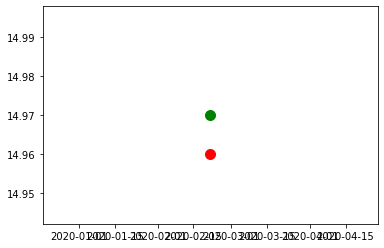

buy time:2020-02-21T15:44:42.382778258Z sell time:2020-02-21T15:44:43.458413755Z
{'rsi': 62.39004689857106, 'macd1': [0.02714077734368736, 0.032862757746501714, 0.03457812407068417, 0.037921181742669674, 0.04010823625214499], 'macd2': [0.055226074237269884, 0.05581513509099345, 0.055788013333318176, 0.056153643394196706, 0.05640022484021934], 'macd_signal': [0.009756042201090703, 0.014377385310172904, 0.018417533062275157, 0.022318262798354062, 0.025876257489112247]}
{'rsi': 61.63252730102167, 'macd': [0.01673333940681232, 0.020428770627601622, 0.02148457715512997, 0.02358670461612533, 0.024658664915390816], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003340013360053962, 'too_close': 0, 'macd_signal': [0.004927195975854214, 0.008027510906203695, 0.01071892415598895, 0.013292480248016226, 0.015565717181491145], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00909294773389967}


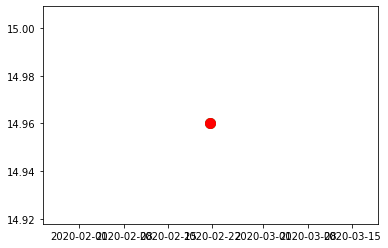

buy time:2020-02-21T15:44:45.542566277Z sell time:2020-02-21T15:45:02.598013274Z
{'rsi': 60.89318214700258, 'macd1': [0.02714077734368736, 0.032862757746501714, 0.03457812407068417, 0.037921181742669674, 0.03931051545442443], 'macd2': [0.055226074237269884, 0.05581513509099345, 0.055788013333318176, 0.056153643394196706, 0.056240288814629835], 'macd_signal': [0.009756042201090703, 0.014377385310172904, 0.018417533062275157, 0.022318262798354062, 0.025716713329568135]}
{'rsi': 60.89318214700258, 'macd': [0.01673333940681232, 0.020428770627601622, 0.02148457715512997, 0.02358670461612533, 0.024398924655653076], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.004927195975854214, 0.008027510906203695, 0.01071892415598895, 0.013292480248016226, 0.015513769129543597], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00888515552610948}


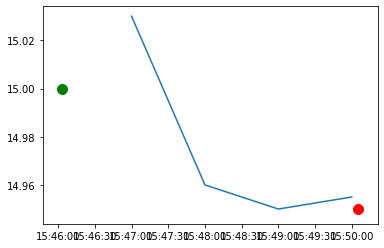

buy time:2020-02-21T15:46:02.86958609Z sell time:2020-02-21T15:50:04.743089279Z
{'rsi': 63.16882962792702, 'macd1': [0.03457812407068417, 0.037921181742669674, 0.03771507385898154, 0.042308977097016864, 0.04502717505163645], 'macd2': [0.055788013333318176, 0.056153643394196706, 0.05592041676345083, 0.056655988077165986, 0.05716215586626916], 'macd_signal': [0.018417533062275157, 0.022318262798354062, 0.025397625010479558, 0.02877989542778702, 0.032029351352556905]}
{'rsi': 54.74537552160756, 'macd': [0.029471301311794207, 0.03159357410068431, 0.02920062336344742, 0.026437277031009287, 0.02394067888844731], 'scalp': 0, 'bail_out': 0, 'movement': -0.003333333333333381, 'too_close': 1, 'macd_signal': [0.019891130219349754, 0.022231618995616664, 0.023625419869182814, 0.02418779130154811, 0.02413836881892795], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00019768993048064135}
VTVT analysis 

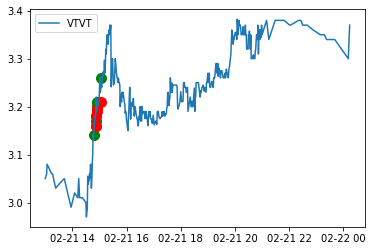

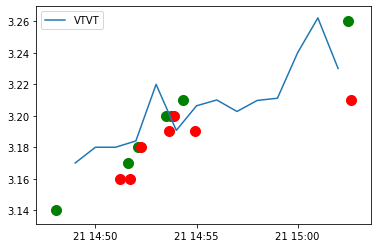

Delta = -0.06999999999999984


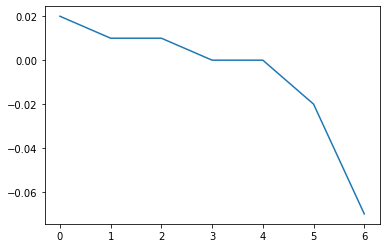

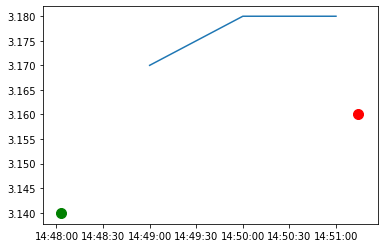

buy time:2020-02-21T14:48:02.98730029Z sell time:2020-02-21T14:51:14.075047Z
{'rsi': 65.39511141683467, 'macd1': [0.03431016197566539, 0.036420747229434, 0.0410496018045583, 0.04365796818900547, 0.045555030533640295], 'macd2': [0.018281359213176085, 0.019487832317046205, 0.021246386208584322, 0.022719975556682925, 0.024109759318277746], 'macd_signal': [0.03099164029337364, 0.032077461680585714, 0.03387188970538023, 0.03582910540210528, 0.03777429042841228]}
{'rsi': 65.00048687001987, 'macd': [0.02683572457141503, 0.0284536900912693, 0.03039426465100936, 0.03203115048131355, 0.03185169592724746], 'scalp': 0, 'bail_out': 0, 'movement': -0.00940438871473348, 'too_close': 0, 'macd_signal': [0.02218222319108324, 0.023436516571120454, 0.024828066187098236, 0.0262686830459413, 0.02738528562220253], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004466410305044927}


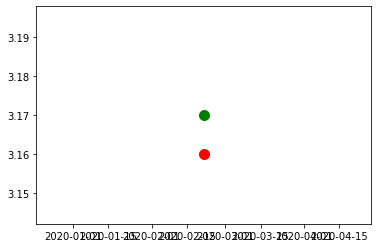

buy time:2020-02-21T14:51:35.777257395Z sell time:2020-02-21T14:51:43.237893046Z
{'rsi': 69.88668068306826, 'macd1': [0.04365796818900547, 0.04633679691540671, 0.04951893569631505, 0.052245466813023, 0.0537782707726886], 'macd2': [0.022719975556682925, 0.02426649662335567, 0.025973605375023023, 0.027662594905645488, 0.029170677484749774], 'macd_signal': [0.03582910540210528, 0.037930643704765565, 0.040248302103075465, 0.04264773504506497, 0.044873842190589694]}
{'rsi': 65.2756916211591, 'macd': [0.02683572457141503, 0.0284536900912693, 0.03039426465100936, 0.03203115048131355, 0.03191403358958489], 'scalp': 0, 'bail_out': 0, 'movement': -0.005880688071951929, 'too_close': 0, 'macd_signal': [0.02218222319108324, 0.023436516571120454, 0.024828066187098236, 0.0262686830459413, 0.027397753154670017], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0045162804349148725}


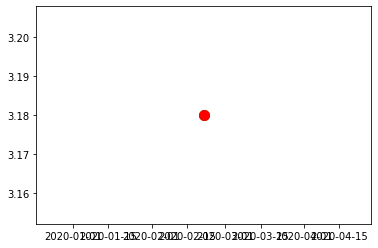

buy time:2020-02-21T14:52:04.89717294Z sell time:2020-02-21T14:52:14.993382394Z
{'rsi': 69.91309014188282, 'macd1': [0.04365796818900547, 0.04633679691540671, 0.04951893569631505, 0.052245466813023, 0.05378624798066589], 'macd2': [0.022719975556682925, 0.02426649662335567, 0.025973605375023023, 0.027662594905645488, 0.029172276845005563], 'macd_signal': [0.03582910540210528, 0.037930643704765565, 0.040248302103075465, 0.04264773504506497, 0.044875437632185156]}
{'rsi': 69.91309014188282, 'macd': [0.0284536900912693, 0.03039426465100936, 0.03203115048131355, 0.03289065696620863, 0.033133250889942456], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.023436516571120454, 0.024828066187098236, 0.0262686830459413, 0.027593077829994768, 0.028701112441984304], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004432138447958152}


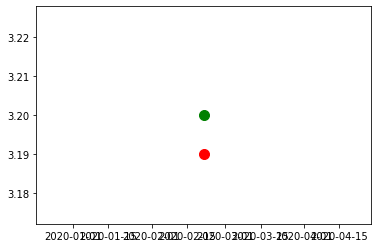

buy time:2020-02-21T14:53:30.508650122Z sell time:2020-02-21T14:53:38.493251592Z
{'rsi': 72.30587245070922, 'macd1': [0.04951893569631505, 0.052245466813023, 0.05378624798066589, 0.054699552337301505, 0.0560681007382291], 'macd2': [0.025973605375023023, 0.027662594905645488, 0.029172276845005563, 0.030578549949798806, 0.03207935771242543], 'macd_signal': [0.040248302103075465, 0.04264773504506497, 0.044875437632185156, 0.04684026057320843, 0.04868582860621256]}
{'rsi': 71.1417056316661, 'macd': [0.03039426465100936, 0.03203115048131355, 0.03289065696620863, 0.03334104309773478, 0.03357068108206995], 'scalp': 0, 'bail_out': 0, 'movement': -0.003125000000000072, 'too_close': 0, 'macd_signal': [0.024828066187098236, 0.0262686830459413, 0.027593077829994768, 0.02874267088354277, 0.029708272923248208], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003862408158821745}


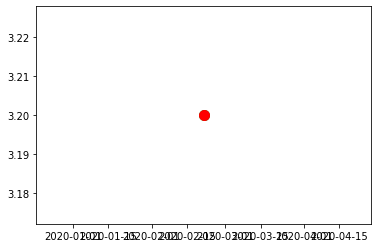

buy time:2020-02-21T14:53:43.381600397Z sell time:2020-02-21T14:53:52.276244438Z
{'rsi': 72.30587245070922, 'macd1': [0.04951893569631505, 0.052245466813023, 0.05378624798066589, 0.054699552337301505, 0.0560681007382291], 'macd2': [0.025973605375023023, 0.027662594905645488, 0.029172276845005563, 0.030578549949798806, 0.03207935771242543], 'macd_signal': [0.040248302103075465, 0.04264773504506497, 0.044875437632185156, 0.04684026057320843, 0.04868582860621256]}
{'rsi': 71.1417056316661, 'macd': [0.03039426465100936, 0.03203115048131355, 0.03289065696620863, 0.03334104309773478, 0.03357068108206995], 'scalp': 0, 'bail_out': 0, 'movement': -0.003125000000000072, 'too_close': 0, 'macd_signal': [0.024828066187098236, 0.0262686830459413, 0.027593077829994768, 0.02874267088354277, 0.029708272923248208], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003862408158821745}


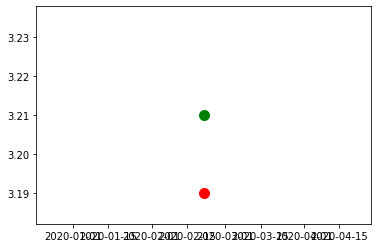

buy time:2020-02-21T14:54:19.314367977Z sell time:2020-02-21T14:54:56.446325832Z
{'rsi': 74.36389301279148, 'macd1': [0.04951893569631505, 0.052245466813023, 0.05378624798066589, 0.054699552337301505, 0.057655565125693364], 'macd2': [0.025973605375023023, 0.027662594905645488, 0.029172276845005563, 0.030578549949798806, 0.03239763040334909], 'macd_signal': [0.040248302103075465, 0.04264773504506497, 0.044875437632185156, 0.04684026057320843, 0.04900332148370541]}
{'rsi': 68.47118095472732, 'macd': [0.03203115048131355, 0.03289065696620863, 0.03334104309773478, 0.03512392783531659, 0.034945345451155685], 'scalp': 0, 'bail_out': 0, 'movement': -0.006646169135687402, 'too_close': 0, 'macd_signal': [0.0262686830459413, 0.027593077829994768, 0.02874267088354277, 0.030018922273897537, 0.031004206909349165], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00394113854180652}


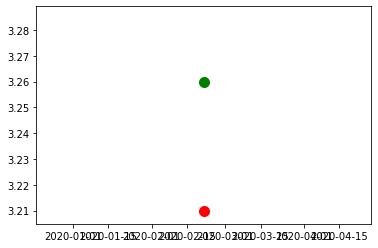

buy time:2020-02-21T15:02:30.85050495Z sell time:2020-02-21T15:02:38.540243035Z
{'rsi': 74.95417580798348, 'macd1': [0.05407106706205811, 0.05261146580732223, 0.05317375581221784, 0.05477129065010233, 0.055654016911691695], 'macd2': [0.037741375175793124, 0.03850890652947303, 0.039615685425394176, 0.04092405627617968, 0.042113526529099055], 'macd_signal': [0.05349326808858053, 0.05331690763232887, 0.053288277268306664, 0.0535848799446658, 0.05399870733807098]}
{'rsi': 60.43933967171825, 'macd': [0.03213650807277402, 0.031086513784677194, 0.031365914160385255, 0.032324331152360664, 0.02995005437789544], 'scalp': 0, 'bail_out': 0, 'movement': -0.016905031696934338, 'too_close': 1, 'macd_signal': [0.03227477010391523, 0.03203711884006762, 0.03190287790413115, 0.03198716855377705, 0.03157974571860073], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001629691340705286}
TRIL analysis for run 6

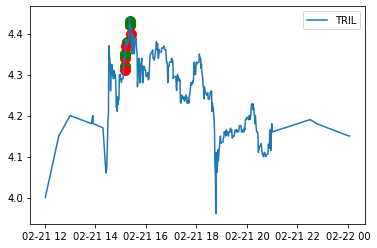

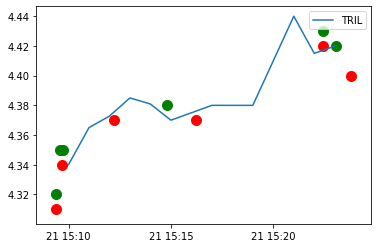

Delta = -0.03999999999999915


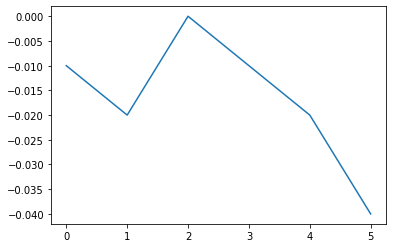

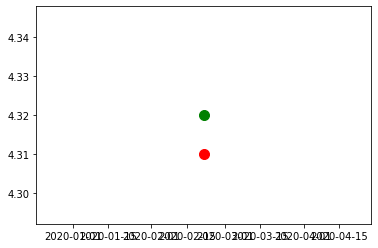

buy time:2020-02-21T15:09:23.134120081Z sell time:2020-02-21T15:09:24.67461865Z
{'rsi': 63.73239386958747, 'macd1': [0.011706391371712144, 0.011658689654074017, 0.011488453953313105, 0.012979141607094569, 0.015833906673652365], 'macd2': [0.023579416682671273, 0.023413748617702623, 0.023223881679692582, 0.023363913926361946, 0.023823233616037776], 'macd_signal': [0.01126257157164413, 0.011341795188130107, 0.011371126941166706, 0.011692729874352279, 0.012520965234212296]}
{'rsi': 56.47692496029434, 'macd': [0.006163982300551041, 0.006095114230178389, 0.007105150613911704, 0.009254462723133017, 0.009250621993654562], 'scalp': 0, 'bail_out': 0, 'movement': -0.005767012687427994, 'too_close': 0, 'macd_signal': [0.005724037876049961, 0.005798253146875647, 0.0060596326402828585, 0.00669859865685289, 0.007209003324213224], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0020416186694413377}


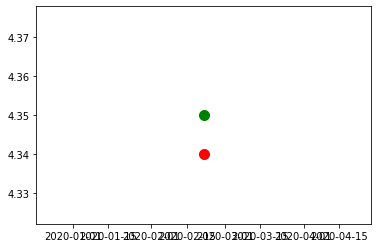

buy time:2020-02-21T15:09:35.179407912Z sell time:2020-02-21T15:09:39.562614109Z
{'rsi': 66.1428752218325, 'macd1': [0.011658689654074017, 0.011488453953313105, 0.012979141607094569, 0.016232767072512644, 0.019394635832341578], 'macd2': [0.023413748617702623, 0.023223881679692582, 0.023363913926361946, 0.023903201628832527, 0.024521069760328196], 'macd_signal': [0.011341795188130107, 0.011371126941166706, 0.011692729874352279, 0.012600737313984351, 0.013959517017655796]}
{'rsi': 65.35664634297795, 'macd': [0.006163982300551041, 0.006095114230178389, 0.007105150613911704, 0.009254462723133017, 0.011068803811836503], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011494252873562975, 'too_close': 0, 'macd_signal': [0.005724037876049961, 0.005798253146875647, 0.0060596326402828585, 0.00669859865685289, 0.007572639687849612], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0034961641239868906}


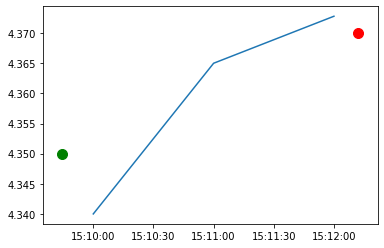

buy time:2020-02-21T15:09:44.334158481Z sell time:2020-02-21T15:12:11.870280349Z
{'rsi': 66.1428752218325, 'macd1': [0.011658689654074017, 0.011488453953313105, 0.012979141607094569, 0.016232767072512644, 0.019394635832341578], 'macd2': [0.023413748617702623, 0.023223881679692582, 0.023363913926361946, 0.023903201628832527, 0.024521069760328196], 'macd_signal': [0.011341795188130107, 0.011371126941166706, 0.011692729874352279, 0.012600737313984351, 0.013959517017655796]}
{'rsi': 69.56757807048959, 'macd': [0.007105150613911704, 0.009254462723133017, 0.010809063552096099, 0.011880063372689875, 0.014118763708571791], 'scalp': 0, 'bail_out': 1, 'movement': 0.006912442396313422, 'too_close': 0, 'macd_signal': [0.0060596326402828585, 0.00669859865685289, 0.0075206916359015314, 0.008392565983259201, 0.00953780552832172], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004580958180250071}


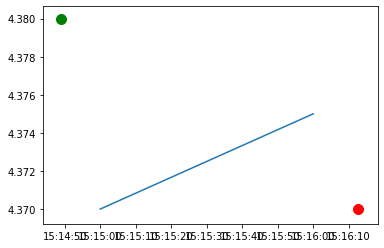

buy time:2020-02-21T15:14:49.046278171Z sell time:2020-02-21T15:16:12.660032172Z
{'rsi': 71.90083934429332, 'macd1': [0.020237237055820145, 0.023286067846722602, 0.026031606866983026, 0.028859233086651948, 0.03074572960534727], 'macd2': [0.024743483691055168, 0.025455524200740598, 0.02619466179209695, 0.027027919269323242, 0.0277513154220701], 'macd_signal': [0.015087425697653235, 0.016727154127467107, 0.018588044675370292, 0.020642282357626624, 0.022662971807170754]}
{'rsi': 67.30479374992427, 'macd': [0.01562627774908787, 0.01743418658371443, 0.018403541694024916, 0.01835364253720151, 0.01838289458984299], 'scalp': 0, 'bail_out': 0, 'movement': -0.002075256556442442, 'too_close': 0, 'macd_signal': [0.010713941530916626, 0.012057990541476186, 0.013327100771985931, 0.014332409125029047, 0.015142506217991836], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0032403883718511543}


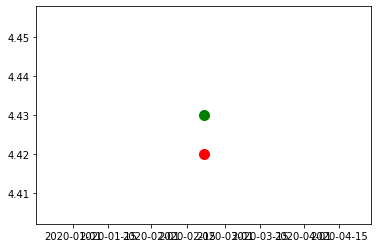

buy time:2020-02-21T15:22:25.171354437Z sell time:2020-02-21T15:22:26.589978407Z
{'rsi': 74.44956571727768, 'macd1': [0.030303215635500536, 0.029743680859268373, 0.03135950197920856, 0.034661247848344345, 0.036175023126460815], 'macd2': [0.029173371710477625, 0.029417720655932733, 0.030075288045324555, 0.031111977933693247, 0.0318800609090637], 'macd_signal': [0.027225850680981427, 0.027729416716638818, 0.028455433769152765, 0.029696596584991082, 0.03099228189328503]}
{'rsi': 71.83988075165432, 'macd': [0.018112088745680488, 0.01769606900305032, 0.018700520255507058, 0.02079878720215511, 0.021384465508605288], 'scalp': 0, 'bail_out': 0, 'movement': -0.001466771973372436, 'too_close': 0, 'macd_signal': [0.016242695329540195, 0.01653337006424222, 0.01696680010249519, 0.017733197522427174, 0.018463451119662796], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0029210143889424924}


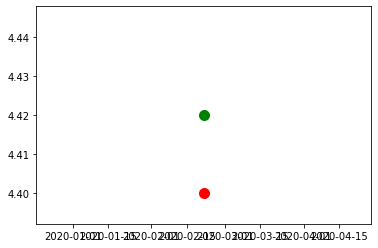

buy time:2020-02-21T15:23:03.470233409Z sell time:2020-02-21T15:23:48.077277566Z
{'rsi': 71.83988075165432, 'macd1': [0.030303215635500536, 0.029743680859268373, 0.03135950197920856, 0.034661247848344345, 0.03565650460794245], 'macd2': [0.029173371710477625, 0.029417720655932733, 0.030075288045324555, 0.031111977933693247, 0.03177610249243035], 'macd_signal': [0.027225850680981427, 0.027729416716638818, 0.028455433769152765, 0.029696596584991082, 0.030888578189581357]}
{'rsi': 62.95989770441827, 'macd': [0.01769606900305032, 0.018700520255507058, 0.02079878720215511, 0.020864984989125368, 0.019866373070023258], 'scalp': 0, 'bail_out': 0, 'movement': -0.005649717514124173, 'too_close': 0, 'macd_signal': [0.01653337006424222, 0.01696680010249519, 0.017733197522427174, 0.01835955501576681, 0.0186609186266181], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001205454443405158}
FNGD analysis f

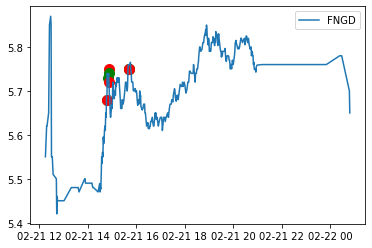

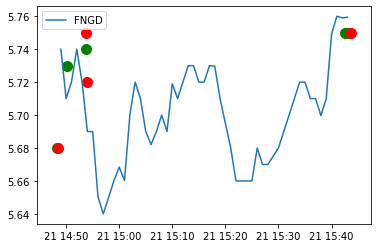

Delta = -8.881784197001252e-16


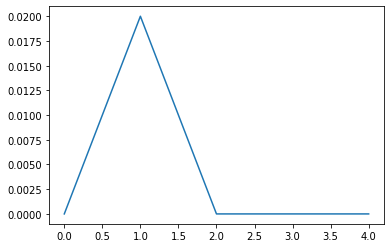

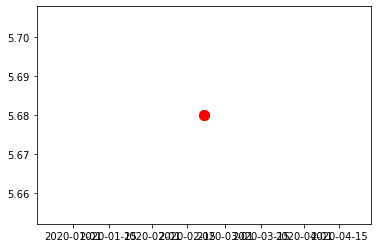

buy time:2020-02-21T14:48:10.992055135Z sell time:2020-02-21T14:48:22.929040269Z
{'rsi': 69.87831498829748, 'macd1': [0.04348344240513935, 0.04682072485962241, 0.04810411453353769, 0.052390484055453435, 0.05451353158338801], 'macd2': [0.011711699349978844, 0.013658373340950547, 0.015267594996233314, 0.01749140493178647, 0.01938145732762031], 'macd_signal': [0.03321374139856299, 0.03593513809077488, 0.03836893337932744, 0.041173243514552635, 0.04384130112831971]}
{'rsi': 69.87831498829748, 'macd': [0.02736670304607358, 0.02937299754319067, 0.030035395884539184, 0.032654986853323464, 0.033856551415319736], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.021218558342926595, 0.022849446182979412, 0.024286636123291367, 0.025960306269297788, 0.027539555298502178], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006316996116817557}


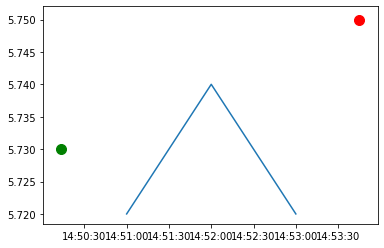

buy time:2020-02-21T14:50:13.403690405Z sell time:2020-02-21T14:53:44.535586955Z
{'rsi': 74.00427254279067, 'macd1': [0.04810411453353769, 0.052390484055453435, 0.055311252381109455, 0.06095787995954538, 0.06388947843313986], 'macd2': [0.015267594996233314, 0.01749140493178647, 0.0195413933532107, 0.022195874674395988, 0.024442647173936294], 'macd_signal': [0.03836893337932744, 0.041173243514552635, 0.044000845287864, 0.047392252222200275, 0.05069169746438819]}
{'rsi': 73.25871049379, 'macd': [0.03786806664848541, 0.03853889802735111, 0.03908059912741102, 0.04003412467125678, 0.04077668841099147], 'scalp': 0, 'bail_out': 1, 'movement': 0.003490401396160484, 'too_close': 0, 'macd_signal': [0.029688374451615613, 0.03145847916676271, 0.03298290315889237, 0.03439314746136525, 0.035669855651290494], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005106832759700974}


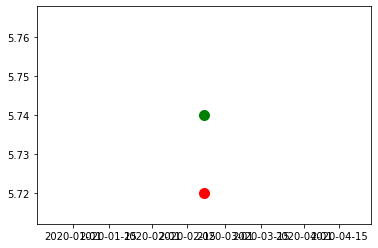

buy time:2020-02-21T14:53:48.391824247Z sell time:2020-02-21T14:53:55.314373924Z
{'rsi': 73.25871049379, 'macd1': [0.06095787995954538, 0.06229403683769785, 0.06342870063867068, 0.065190289649248, 0.06662526349344056], 'macd2': [0.022195874674395988, 0.0241227751227564, 0.026016940189204085, 0.028037894230443783, 0.030012329924953285], 'macd_signal': [0.047392252222200275, 0.05037260914529979, 0.052983827443973966, 0.055425119885028774, 0.05766514860671113]}
{'rsi': 67.53319240167217, 'macd': [0.03786806664848541, 0.03853889802735111, 0.03908059912741102, 0.04003412467125678, 0.039218246852549044], 'scalp': 0, 'bail_out': 0, 'movement': -0.005217391304347869, 'too_close': 0, 'macd_signal': [0.029688374451615613, 0.03145847916676271, 0.03298290315889237, 0.03439314746136525, 0.03535816733960201], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0038600795129470344}


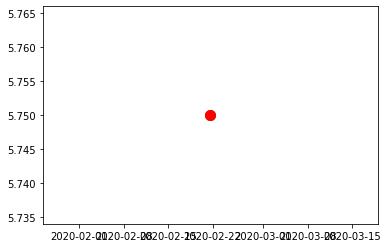

buy time:2020-02-21T15:42:32.142261818Z sell time:2020-02-21T15:43:05.124341188Z
{'rsi': 68.61847320066462, 'macd1': [0.006676794058109614, 0.006965030340635003, 0.010222594033889365, 0.013535812380069956, 0.015897612367759884], 'macd2': [0.022169700003913384, 0.02189803529654366, 0.022236822728433303, 0.02268888294029381, 0.023052511495164296], 'macd_signal': [0.00502107820914981, 0.005409868635446849, 0.006372413715135352, 0.007805093448122273, 0.009423597232049795]}
{'rsi': 65.44417986370824, 'macd': [0.0036751628694142724, 0.005828932762222294, 0.00800292316230422, 0.009541059536883445, 0.01026245074386889], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011807605487063968, 'too_close': 0, 'macd_signal': [0.0024068047146695256, 0.0030912303241800794, 0.004073568891804907, 0.005167067020820615, 0.00618614376543027], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004076306978438619}


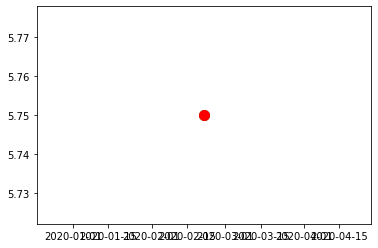

buy time:2020-02-21T15:43:10.609845856Z sell time:2020-02-21T15:43:42.392877571Z
{'rsi': 68.13248986730976, 'macd1': [0.006965030340635003, 0.010222594033889365, 0.013535812380069956, 0.015897612367759884, 0.017487084012043574], 'macd2': [0.02189803529654366, 0.022236822728433303, 0.02268888294029381, 0.023052511495164296, 0.023334198523862426], 'macd_signal': [0.005409868635446849, 0.006372413715135352, 0.007805093448122273, 0.009423597232049795, 0.011036294588048551]}
{'rsi': 64.47915366570547, 'macd': [0.0036751628694142724, 0.005828932762222294, 0.00800292316230422, 0.009541059536883445, 0.010148165029582934], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013893713094824604, 'too_close': 0, 'macd_signal': [0.0024068047146695256, 0.0030912303241800794, 0.004073568891804907, 0.005167067020820615, 0.006163286622573079], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003984878407009855}
KGC 

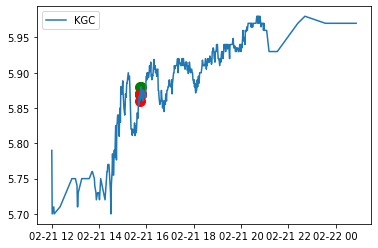

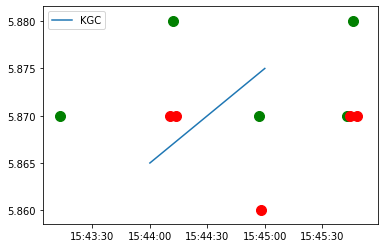

Delta = -0.02999999999999936


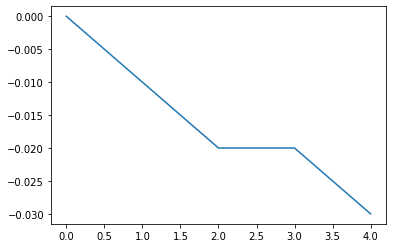

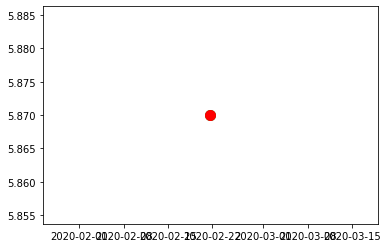

buy time:2020-02-21T15:43:13.028008582Z sell time:2020-02-21T15:44:10.516574457Z
{'rsi': 62.05971948382235, 'macd1': [-0.0028135525405925677, -0.0003430938994704036, 0.001197500123054418, 0.00334813646408616, 0.005234268794364283], 'macd2': [0.015027049374047863, 0.015000986382010417, 0.014873047601440703, 0.014923475700401312, 0.014993983958261126], 'macd_signal': [-0.005857691007453208, -0.004754771585856648, -0.0035643172440744343, -0.0021818265024423156, -0.0006986074430809959]}
{'rsi': 62.05971948382235, 'macd': [-0.0019787913797282286, -0.00032727487795725096, 0.0007041311607993705, 0.00212205624085815, 0.0033552179105029722], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.004305578493753742, -0.0035099177705944437, -0.0026671079843156808, -0.0017092751392809146, -0.0006963765293241371], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00405159443982710

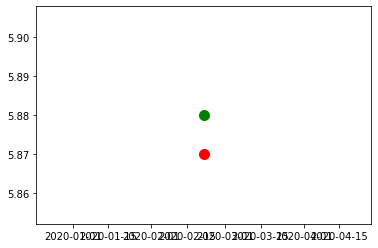

buy time:2020-02-21T15:44:12.007182874Z sell time:2020-02-21T15:44:13.622645806Z
{'rsi': 63.87035073622652, 'macd1': [-0.0003430938994704036, 0.001197500123054418, 0.00334813646408616, 0.004436547996642837, 0.006834174718769681], 'macd2': [0.015000986382010417, 0.014873047601440703, 0.014923475700401312, 0.014834047932671623, 0.015047918590297193], 'macd_signal': [-0.004754771585856648, -0.0035643172440744343, -0.0021818265024423156, -0.0008581516026252851, 0.0006803136616537083]}
{'rsi': 62.511300546064305, 'macd': [-0.00032727487795725096, 0.0007041311607993705, 0.00212205624085815, 0.002835737391023052, 0.004134245593865771], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008503401360544036, 'too_close': 0, 'macd_signal': [-0.0035099177705944437, -0.0026671079843156808, -0.0017092751392809146, -0.0008002726332201212, 0.00018663101219705742], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0

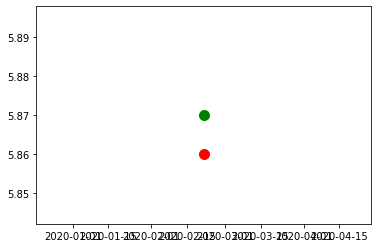

buy time:2020-02-21T15:44:56.807274136Z sell time:2020-02-21T15:44:57.925841364Z
{'rsi': 63.338729123505544, 'macd1': [-0.0003430938994704036, 0.001197500123054418, 0.00334813646408616, 0.004436547996642837, 0.0066746305592255695], 'macd2': [0.015000986382010417, 0.014873047601440703, 0.014923475700401312, 0.014834047932671623, 0.015015931385179648], 'macd_signal': [-0.004754771585856648, -0.0035643172440744343, -0.0021818265024423156, -0.0008581516026252851, 0.0006484048297448859]}
{'rsi': 59.46151531763728, 'macd': [-0.00032727487795725096, 0.0007041311607993705, 0.00212205624085815, 0.002835737391023052, 0.0036147650743849624], 'scalp': 0, 'bail_out': 0, 'movement': -0.002211636611092191, 'too_close': 0, 'macd_signal': [-0.0035099177705944437, -0.0026671079843156808, -0.0017092751392809146, -0.0008002726332201212, 8.273490830089565e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0

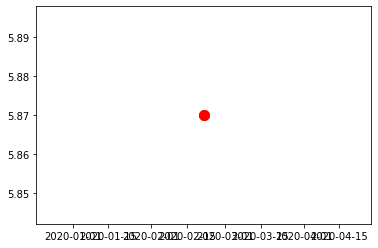

buy time:2020-02-21T15:45:42.702952877Z sell time:2020-02-21T15:45:44.650129284Z
{'rsi': 61.162779320409456, 'macd1': [0.001197500123054418, 0.00334813646408616, 0.004436547996642837, 0.005637593522188844, 0.006913197925141112], 'macd2': [0.014873047601440703, 0.014923475700401312, 0.014834047932671623, 0.014808014551913828, 0.014840347671732701], 'macd_signal': [-0.0035643172440744343, -0.0021818265024423156, -0.0008581516026252851, 0.00044099742233754085, 0.0017354375228982551]}
{'rsi': 61.162779320409456, 'macd': [0.0007041311607993705, 0.00212205624085815, 0.002835737391023052, 0.0036147650743849624, 0.004434594891623789], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.0026671079843156808, -0.0017092751392809146, -0.0008002726332201212, 8.273490830089565e-05, 0.0009531069049654743], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003481487986658314}


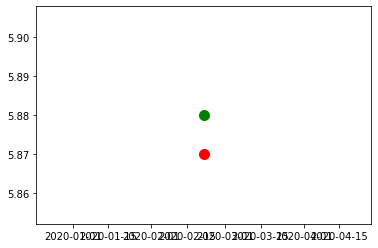

buy time:2020-02-21T15:45:46.121477155Z sell time:2020-02-21T15:45:48.393471413Z
{'rsi': 64.17010033866582, 'macd1': [0.001197500123054418, 0.00334813646408616, 0.004436547996642837, 0.005637593522188844, 0.007710918722862559], 'macd2': [0.014873047601440703, 0.014923475700401312, 0.014834047932671623, 0.014808014551913828, 0.015000283697323091], 'macd_signal': [-0.0035643172440744343, -0.0021818265024423156, -0.0008581516026252851, 0.00044099742233754085, 0.0018949816824425445]}
{'rsi': 62.727001825671614, 'macd': [0.0007041311607993705, 0.00212205624085815, 0.002835737391023052, 0.0036147650743849624, 0.004694335151363305], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008503401360544036, 'too_close': 0, 'macd_signal': [-0.0026671079843156808, -0.0017092751392809146, -0.0008002726332201212, 8.273490830089565e-05, 0.0010050549569133775], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003689

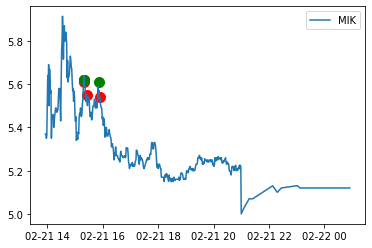

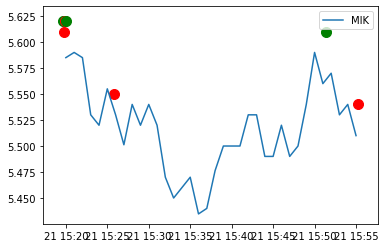

Delta = -0.15000000000000036


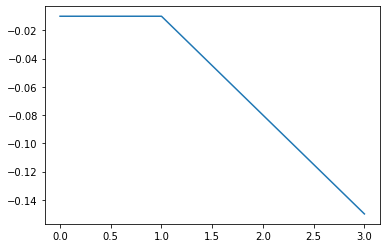

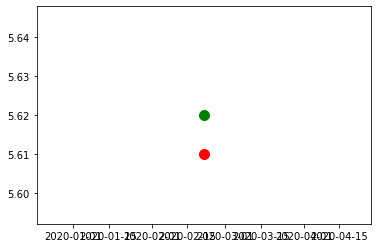

buy time:2020-02-21T15:19:38.91012511Z sell time:2020-02-21T15:19:43.465224054Z
{'rsi': 62.03557400372461, 'macd1': [-0.029821158920030122, -0.0232828462062713, -0.015900602955248644, -0.005149265901539302, 0.0057259898060850745], 'macd2': [0.01849127427659436, 0.018169982089221826, 0.018245162716370444, 0.019244766863592666, 0.020613463415093847], 'macd_signal': [-0.03975745279946979, -0.03646253148083009, -0.0323501457757138, -0.026909969800878904, -0.020382777879486107]}
{'rsi': 61.91192054642729, 'macd': [-0.01872385090592754, -0.014287482560158438, -0.009346319140595583, -0.0022577980456048863, 0.0047703716134224194], 'scalp': 0, 'bail_out': 0, 'movement': -0.0002846975088967658, 'too_close': 0, 'macd_signal': [-0.026534847072409124, -0.024085374169958988, -0.021137563164086305, -0.017361610140390022, -0.012935213789627534], 'below_cost_base': 1, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.017705585403

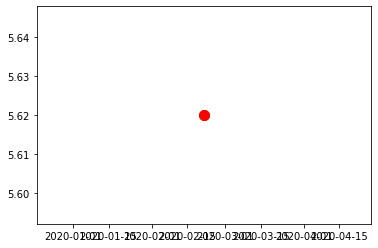

buy time:2020-02-21T15:19:49.497773735Z sell time:2020-02-21T15:19:50.683495605Z
{'rsi': 62.03557400372461, 'macd1': [-0.029821158920030122, -0.0232828462062713, -0.015900602955248644, -0.005149265901539302, 0.0057259898060850745], 'macd2': [0.01849127427659436, 0.018169982089221826, 0.018245162716370444, 0.019244766863592666, 0.020613463415093847], 'macd_signal': [-0.03975745279946979, -0.03646253148083009, -0.0323501457757138, -0.026909969800878904, -0.020382777879486107]}
{'rsi': 62.03557400372461, 'macd': [-0.01872385090592754, -0.014287482560158438, -0.009346319140595583, -0.0022577980456048863, 0.0048534884965389935], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.026534847072409124, -0.024085374169958988, -0.021137563164086305, -0.017361610140390022, -0.012918590413004218], 'below_cost_base': 1, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.017772078909543212}


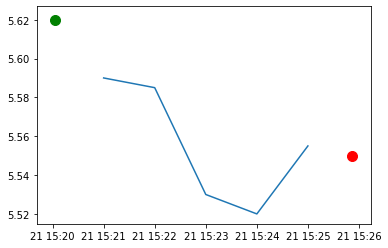

buy time:2020-02-21T15:20:03.020530363Z sell time:2020-02-21T15:25:51.735469058Z
{'rsi': 62.23480745477822, 'macd1': [-0.029821158920030122, -0.0232828462062713, -0.015900602955248644, -0.005149265901539302, 0.0059333972134929525], 'macd2': [0.01849127427659436, 0.018169982089221826, 0.018245162716370444, 0.019244766863592666, 0.02065504678174701], 'macd_signal': [-0.03975745279946979, -0.03646253148083009, -0.0323501457757138, -0.026909969800878904, -0.020341296398004534]}
{'rsi': 53.5783398963819, 'macd': [0.012111192748648136, 0.013877205142517113, 0.012215952395629337, 0.010243340483826024, 0.010640742364449451], 'scalp': 0, 'bail_out': 0, 'movement': -0.011169209974033398, 'too_close': 0, 'macd_signal': [-0.004223132520693248, -0.0006030649880511755, 0.0019607384886849272, 0.003617258887713147, 0.005021955583060408], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0056187867813890435}

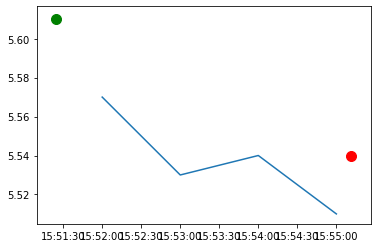

buy time:2020-02-21T15:51:24.215005904Z sell time:2020-02-21T15:55:11.620432385Z
{'rsi': 64.2816364685493, 'macd1': [-0.001900957432484418, -0.0016752209967609843, 0.0017116120625297881, 0.00833421218519348, 0.015023323823346146], 'macd2': [0.007148252966697299, 0.006875420072747218, 0.007253152911903982, 0.008388758929997131, 0.009740008195056937], 'macd_signal': [-0.004367173794315341, -0.00382878323480447, -0.002720704175337618, -0.0005097209032313985, 0.0025968880420841104]}
{'rsi': 53.07181381012194, 'macd': [0.007470512649314642, 0.009224090104826388, 0.008392798640226573, 0.008155522191964693, 0.007864715580436332], 'scalp': 0, 'bail_out': 0, 'movement': -0.0018018018018017634, 'too_close': 0, 'macd_signal': [0.0015083999925552332, 0.0030515380150094645, 0.004119790140052886, 0.0049269365504352475, 0.005514492356435465], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00235022322400

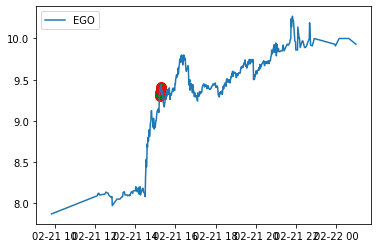

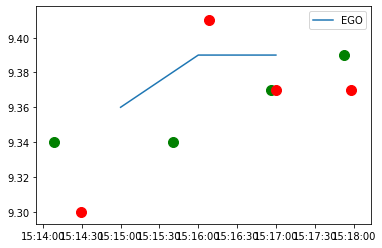

Delta = 0.009999999999999787


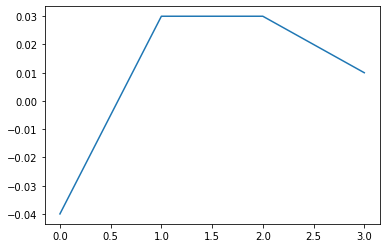

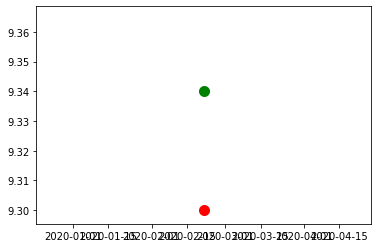

buy time:2020-02-21T15:14:08.719478819Z sell time:2020-02-21T15:14:29.707294705Z
{'rsi': 74.6088682191562, 'macd1': [0.11945064730323374, 0.11324683595518081, 0.11866268933257373, 0.13284932443642639, 0.1403283197521361], 'macd2': [0.20017814557906988, 0.19855753400508291, 0.19906802686083402, 0.20148400924933263, 0.2029591149826171], 'macd_signal': [0.13614093202895686, 0.13156211281420166, 0.12898222811787607, 0.12975564738158613, 0.13187018185569613]}
{'rsi': 66.81593272453291, 'macd': [0.0627300148889951, 0.05907375885343136, 0.06299000403541477, 0.07257941581312366, 0.07357143257740262], 'scalp': 0, 'bail_out': 0, 'movement': -0.008547008547008555, 'too_close': 0, 'macd_signal': [0.07222752799400131, 0.06959677416588732, 0.0682754201397928, 0.06913621927445898, 0.07002326193504771], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0035481706423549086}


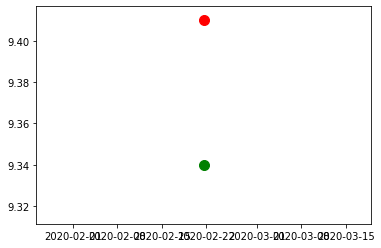

buy time:2020-02-21T15:15:40.229396821Z sell time:2020-02-21T15:16:08.549363409Z
{'rsi': 71.61060663403886, 'macd1': [0.11324683595518081, 0.11866268933257373, 0.13284932443642639, 0.14351920294302012, 0.14575207980211147], 'macd2': [0.19855753400508291, 0.19906802686083402, 0.20148400924933263, 0.2035988590849751, 0.204318520834466], 'macd_signal': [0.13156211281420166, 0.12898222811787607, 0.12975564738158613, 0.13250835849387294, 0.13515710275552065]}
{'rsi': 74.20273096758496, 'macd': [0.06299000403541477, 0.07257941581312366, 0.07980519881116876, 0.0823213258380715, 0.08425179721178644], 'scalp': 0, 'bail_out': 1, 'movement': 0.0038849706219164426, 'too_close': 0, 'macd_signal': [0.0682754201397928, 0.06913621927445898, 0.07127001518180094, 0.07348027731305505, 0.07563458129280133], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008617215918985108}


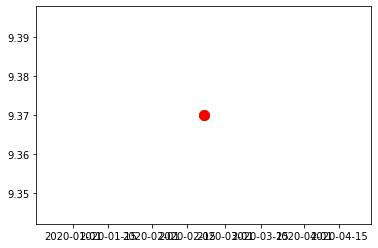

buy time:2020-02-21T15:16:55.93155339Z sell time:2020-02-21T15:16:59.93240266Z
{'rsi': 74.98781360167294, 'macd1': [0.11866268933257373, 0.13284932443642639, 0.14351920294302012, 0.1470523647023949, 0.1513355841468922], 'macd2': [0.19906802686083402, 0.20148400924933263, 0.2035988590849751, 0.2045792165561764, 0.2057937250227937], 'macd_signal': [0.12898222811787607, 0.12975564738158613, 0.13250835849387294, 0.13541715973557733, 0.1386008446178403]}
{'rsi': 73.79141334181534, 'macd': [0.06299000403541477, 0.07257941581312366, 0.07980519881116876, 0.0823213258380715, 0.0837323166923074], 'scalp': 0, 'bail_out': 0, 'movement': -0.0031914893617022485, 'too_close': 0, 'macd_signal': [0.0682754201397928, 0.06913621927445898, 0.07127001518180094, 0.07348027731305505, 0.07553068518890552], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00820163150340189}


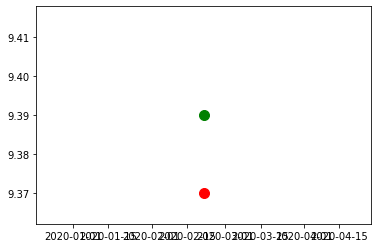

buy time:2020-02-21T15:17:52.224661156Z sell time:2020-02-21T15:17:58.150486894Z
{'rsi': 74.60133763936578, 'macd1': [0.13284932443642639, 0.14351920294302012, 0.1470523647023949, 0.1505378633491734, 0.15155313592600272], 'macd2': [0.20148400924933263, 0.2035988590849751, 0.2045792165561764, 0.20563378899720242, 0.20627514686638015], 'macd_signal': [0.12975564738158613, 0.13250835849387294, 0.13541715973557733, 0.13844130045829656, 0.1410636675518378]}
{'rsi': 72.19855751703714, 'macd': [0.07257941581312366, 0.07980519881116876, 0.0823213258380715, 0.08477127773126725, 0.08454044443075404], 'scalp': 0, 'bail_out': 0, 'movement': -0.0021299254526093024, 'too_close': 0, 'macd_signal': [0.06913621927445898, 0.07127001518180094, 0.07348027731305505, 0.07573847739669749, 0.0774988708035088], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.007041573627245237}
VIXY analysis for run 69
2020-02-21T

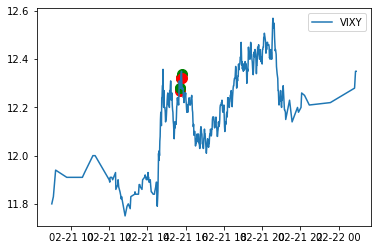

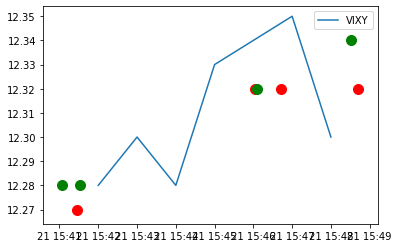

Delta = 0.010000000000001563


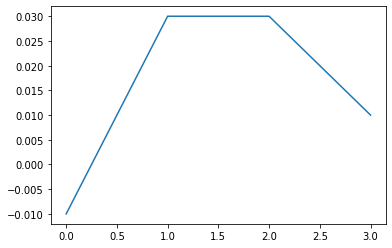

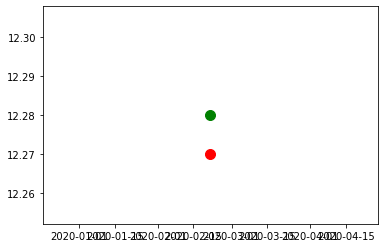

buy time:2020-02-21T15:41:03.860579867Z sell time:2020-02-21T15:41:27.677058251Z
{'rsi': 63.86577056856372, 'macd1': [0.009588846039317644, 0.011166174810110618, 0.0114131853876831, 0.014667530593614586, 0.02024096309861889], 'macd2': [0.047277169562217836, 0.04665185193636212, 0.04582919569292443, 0.04563877234269498, 0.04603032803312068], 'macd_signal': [-0.0021015449061079867, 0.0005519990371357347, 0.0027242363072452077, 0.005112895164519083, 0.008138508751339046]}
{'rsi': 59.5213871940665, 'macd': [0.0063030836034361215, 0.006513467007360774, 0.008670733724608581, 0.013355996962403083, 0.014942487836497875], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013344182262000881, 'too_close': 0, 'macd_signal': [-0.0012831598732623087, 0.0002761655028623079, 0.0019550791472115626, 0.004235262710249867, 0.006376707735499469], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008565780100998406}


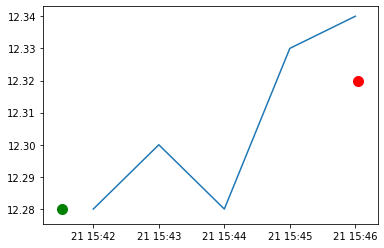

buy time:2020-02-21T15:41:31.761646686Z sell time:2020-02-21T15:46:02.117380463Z
{'rsi': 60.53927948535629, 'macd1': [0.011166174810110618, 0.0114131853876831, 0.014667530593614586, 0.021836404694060008, 0.024811033636643387], 'macd2': [0.04665185193636212, 0.04582919569292443, 0.04563877234269498, 0.04635020008429791, 0.04645079761852067], 'macd_signal': [0.0005519990371357347, 0.0027242363072452077, 0.005112895164519083, 0.008457597070427269, 0.011728284383670493]}
{'rsi': 62.6884840640771, 'macd': [0.017367958619921353, 0.019002693348488364, 0.018990763353237128, 0.021332236560141382, 0.02236023858421987], 'scalp': 0, 'bail_out': 1, 'movement': 0.0032573289902280886, 'too_close': 0, 'macd_signal': [0.008794386483812595, 0.010836047856747749, 0.012466990956045625, 0.014240040076864777, 0.015864079778335795], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006496158805884077}


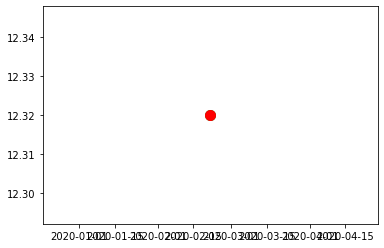

buy time:2020-02-21T15:46:05.359434324Z sell time:2020-02-21T15:46:42.644434571Z
{'rsi': 62.6884840640771, 'macd1': [0.028090644739286574, 0.03068547105132069, 0.030773321055891145, 0.0344800602782076, 0.03619354473696745], 'macd2': [0.04676283993652852, 0.04700071775508974, 0.04682452982605767, 0.047387222131533235, 0.047669191786219756], 'macd_signal': [0.015256027110064288, 0.018341915898315568, 0.020828196929830685, 0.023558569599506068, 0.026085564626998344]}
{'rsi': 62.6884840640771, 'macd': [0.017367958619921353, 0.019002693348488364, 0.018990763353237128, 0.021332236560141382, 0.02236023858421987], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.008794386483812595, 0.010836047856747749, 0.012466990956045625, 0.014240040076864777, 0.015864079778335795], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006496158805884077}


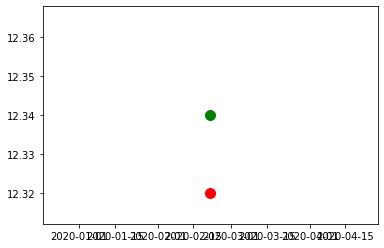

buy time:2020-02-21T15:48:31.529963427Z sell time:2020-02-21T15:48:41.368465532Z
{'rsi': 65.55290934685124, 'macd1': [0.03068547105132069, 0.030773321055891145, 0.0344800602782076, 0.03778898633240679, 0.039950806046297416], 'macd2': [0.04700071775508974, 0.04682452982605767, 0.047387222131533235, 0.04798906383739876, 0.04846602565661051], 'macd_signal': [0.018341915898315568, 0.020828196929830685, 0.023558569599506068, 0.026404652946086214, 0.029113883566128453]}
{'rsi': 60.731786462710446, 'macd': [0.018990763353237128, 0.021332236560141382, 0.023399199623181488, 0.02522541500187181, 0.02476759042680321], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016126418152349925, 'too_close': 0, 'macd_signal': [0.012466990956045625, 0.014240040076864777, 0.016071871986128118, 0.017902580589276858, 0.019275582556782127], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005492007870021083}
AUY analysis 

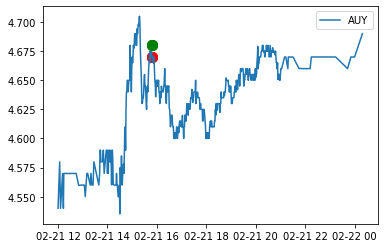

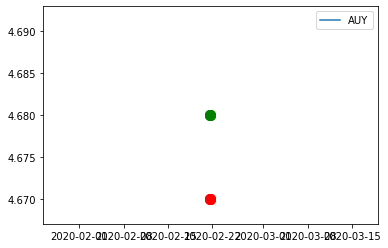

Delta = -0.03999999999999915


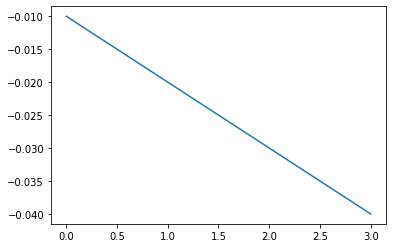

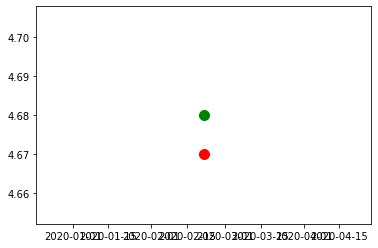

buy time:2020-02-21T15:47:35.348075619Z sell time:2020-02-21T15:47:39.658492041Z
{'rsi': 61.05795736909201, 'macd1': [0.0016074164630497378, 0.0022311976514854948, 0.0034044598629208167, 0.003973774018741771, 0.005172253496734669], 'macd2': [0.012977737195300598, 0.012793619892354613, 0.012746107539836515, 0.012619633987935863, 0.012643026959197279], 'macd_signal': [-0.0027908027381932403, -0.0017864026602574933, -0.0007482301556218313, 0.00019617067925088933, 0.0011913872427476455]}
{'rsi': 59.042342336335615, 'macd': [0.0009431832559387843, 0.0013646062906431666, 0.0021376033788458315, 0.0025095802868104755, 0.0030265807308511583], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010683760683760457, 'too_close': 0, 'macd_signal': [-0.0021587309382065127, -0.0014540634924365768, -0.000735730118180095, -8.666803718198083e-05, 0.0005359817164246471], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 

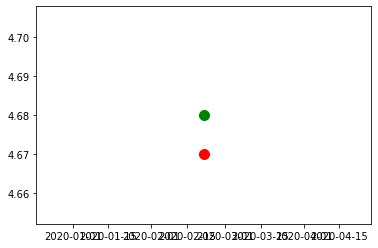

buy time:2020-02-21T15:47:41.346099256Z sell time:2020-02-21T15:47:42.881645478Z
{'rsi': 61.05795736909201, 'macd1': [0.0016074164630497378, 0.0022311976514854948, 0.0034044598629208167, 0.003973774018741771, 0.005172253496734669], 'macd2': [0.012977737195300598, 0.012793619892354613, 0.012746107539836515, 0.012619633987935863, 0.012643026959197279], 'macd_signal': [-0.0027908027381932403, -0.0017864026602574933, -0.0007482301556218313, 0.00019617067925088933, 0.0011913872427476455]}
{'rsi': 58.043384541651776, 'macd': [0.0009431832559387843, 0.0013646062906431666, 0.0021376033788458315, 0.0025095802868104755, 0.002907100211370306], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015598290598290304, 'too_close': 0, 'macd_signal': [-0.0021587309382065127, -0.0014540634924365768, -0.000735730118180095, -8.666803718198083e-05, 0.0005120856125284765], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0

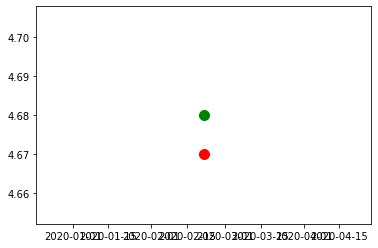

buy time:2020-02-21T15:48:19.418303801Z sell time:2020-02-21T15:48:20.808812349Z
{'rsi': 61.21359496663135, 'macd1': [0.0022311976514854948, 0.0034044598629208167, 0.003973774018741771, 0.004749461473943839, 0.0057258609163506335], 'macd2': [0.012793619892354613, 0.012746107539836515, 0.012619633987935863, 0.012558260865635162, 0.012566476540214921], 'macd_signal': [-0.0017864026602574933, -0.0007482301556218313, 0.00019617067925088933, 0.0011068288381894794, 0.0020306352538217104]}
{'rsi': 60.29132942025254, 'macd': [0.0013646062906431666, 0.0021376033788458315, 0.0025095802868104755, 0.0030109963152655794, 0.003523645216461091], 'scalp': 0, 'bail_out': 0, 'movement': -0.00047008547008532345, 'too_close': 0, 'macd_signal': [-0.0014540634924365768, -0.000735730118180095, -8.666803718198083e-05, 0.0005328648333075312, 0.0011310209099382432], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0

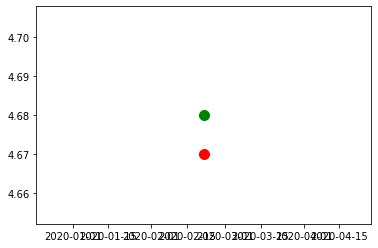

buy time:2020-02-21T15:48:43.757540973Z sell time:2020-02-21T15:48:46.574013126Z
{'rsi': 61.21359496663135, 'macd1': [0.0022311976514854948, 0.0034044598629208167, 0.003973774018741771, 0.004749461473943839, 0.0057258609163506335], 'macd2': [0.012793619892354613, 0.012746107539836515, 0.012619633987935863, 0.012558260865635162, 0.012566476540214921], 'macd_signal': [-0.0017864026602574933, -0.0007482301556218313, 0.00019617067925088933, 0.0011068288381894794, 0.0020306352538217104]}
{'rsi': 55.97283840066051, 'macd': [0.0013646062906431666, 0.0021376033788458315, 0.0025095802868104755, 0.0030109963152655794, 0.003118450411266238], 'scalp': 0, 'bail_out': 0, 'movement': -0.0021367521367520914, 'too_close': 0, 'macd_signal': [-0.0014540634924365768, -0.000735730118180095, -8.666803718198083e-05, 0.0005328648333075312, 0.0010499819488992727], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00

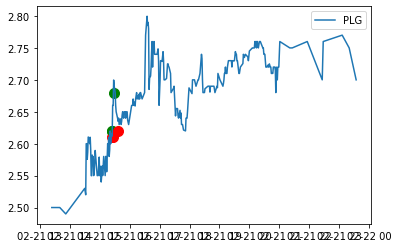

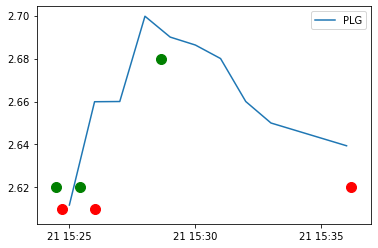

Delta = -0.08000000000000052


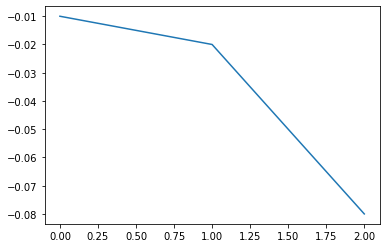

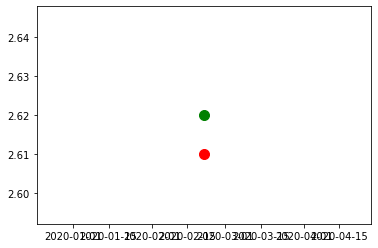

buy time:2020-02-21T15:24:28.996942526Z sell time:2020-02-21T15:24:43.599306678Z
{'rsi': 58.19713635556828, 'macd1': [0.010784184043880707, 0.013190663442791628, 0.013330319228915588, 0.014436541634238687, 0.015585444753688726], 'macd2': [0.016951995090356053, 0.017401246809685578, 0.017466869848045352, 0.01772961720185373, 0.018032561301136063], 'macd_signal': [0.009054804552169757, 0.009881976330294131, 0.010571644910018423, 0.011344624254862476, 0.012192788354627726]}
{'rsi': 57.37881242735685, 'macd': [0.006080705731673852, 0.007661563722484388, 0.007754939251395143, 0.008475037855073975, 0.008957257054627465], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019083969465648447, 'too_close': 0, 'macd_signal': [0.004814096385043732, 0.005383589852531863, 0.005857859732304519, 0.00638129535685841, 0.006896487696412221], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0020607693582152444}


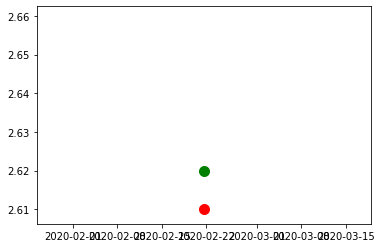

buy time:2020-02-21T15:25:24.90457346Z sell time:2020-02-21T15:26:00.639963166Z
{'rsi': 58.2587847032479, 'macd1': [0.013190663442791628, 0.013330319228915588, 0.014436541634238687, 0.015186584354828003, 0.01600001857346811], 'macd2': [0.017401246809685578, 0.017466869848045352, 0.01772961720185373, 0.017952593288340868, 0.01820899376889029], 'macd_signal': [0.009881976330294131, 0.010571644910018423, 0.011344624254862476, 0.012113016274855582, 0.012890416734578088]}
{'rsi': 56.61495025389291, 'macd': [0.007661563722484388, 0.007754939251395143, 0.008475037855073975, 0.008957257054627465, 0.009050450495128981], 'scalp': 0, 'bail_out': 0, 'movement': -0.0031297709923664065, 'too_close': 0, 'macd_signal': [0.005383589852531863, 0.005857859732304519, 0.00638129535685841, 0.006896487696412221, 0.007327280256155573], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0017231702389734083}


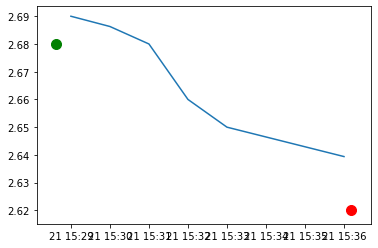

buy time:2020-02-21T15:28:37.494036654Z sell time:2020-02-21T15:36:11.315080248Z
{'rsi': 67.13005014218683, 'macd1': [0.015186584354828003, 0.015345887519337076, 0.019132852818946056, 0.02188978742326686, 0.02539576425088841], 'macd2': [0.017952593288340868, 0.018077846227906758, 0.018933462233116316, 0.019691974259927747, 0.02067820707746204], 'macd_signal': [0.012113016274855582, 0.01275959052375188, 0.014034242982790716, 0.015605351870885945, 0.01756343434688644]}
{'rsi': 49.51202577162265, 'macd': [0.01936018235159942, 0.019555412428444274, 0.01841461232691488, 0.01676704585394484, 0.013717422032748505], 'scalp': 0, 'bail_out': 0, 'movement': -0.011245283018867859, 'too_close': 1, 'macd_signal': [0.013630303392007015, 0.014815325199294467, 0.01553518262481855, 0.01578155527064381, 0.015368728623064747], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001651306590316242}
SCO analysis f

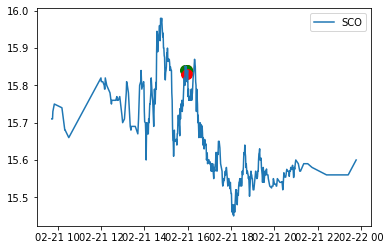

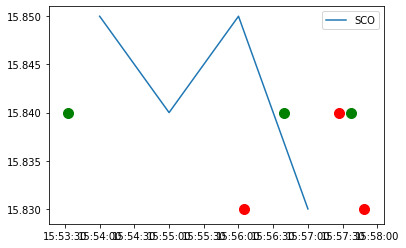

Delta = -0.019999999999999574


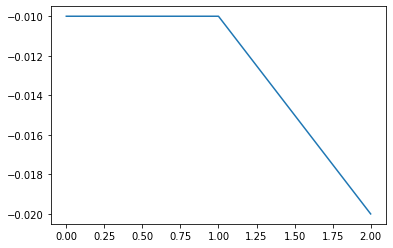

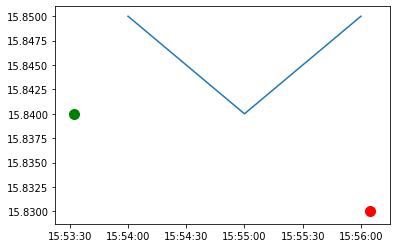

buy time:2020-02-21T15:53:32.404712823Z sell time:2020-02-21T15:56:04.815793688Z
{'rsi': 65.31216660862069, 'macd1': [0.012108867055472317, 0.01721578186579542, 0.021020734701624022, 0.02216682897810962, 0.026003035844551547], 'macd2': [0.012602753401784739, 0.013585529331667345, 0.014467986467746385, 0.014936863686557444, 0.01598410040216791], 'macd_signal': [0.0016022757544380162, 0.004724976976709497, 0.007984128521692401, 0.010820668612975846, 0.013857142059290986]}
{'rsi': 62.131414524172236, 'macd': [0.015161364008655198, 0.018128154515675732, 0.020095417839124607, 0.020847890327017282, 0.0208050391445056], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004356060606060547, 'too_close': 0, 'macd_signal': [0.008220117410592418, 0.01020172483160908, 0.012180463433112186, 0.013913948811893204, 0.015292166878415683], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005512872266089916}


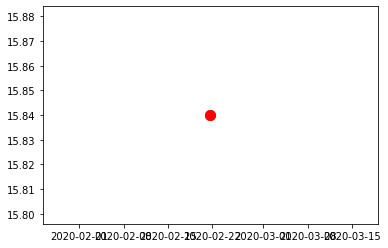

buy time:2020-02-21T15:56:38.937825204Z sell time:2020-02-21T15:57:26.788701283Z
{'rsi': 64.49057611896708, 'macd1': [0.02216682897810962, 0.026968278009794844, 0.030255244880660115, 0.031687993911900136, 0.032848261740799245], 'macd2': [0.014936863686557444, 0.01617762299312986, 0.017259700830974722, 0.018067706549310003, 0.018862168897049614], 'macd_signal': [0.010820668612975846, 0.014050190492339645, 0.01729120137000374, 0.020170559878383017, 0.02270610025086626]}
{'rsi': 63.867474823691914, 'macd': [0.018128154515675732, 0.020095417839124607, 0.020847890327017282, 0.021682961222428077, 0.02179232865752212], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.01020172483160908, 0.012180463433112186, 0.013913948811893204, 0.015467751294000178, 0.016732666766704568], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005059661890817552}


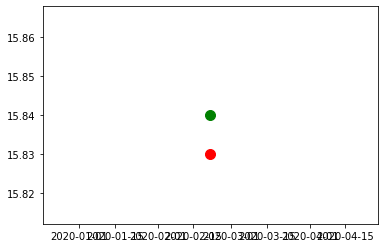

buy time:2020-02-21T15:57:37.191832747Z sell time:2020-02-21T15:57:48.349976449Z
{'rsi': 63.867474823691914, 'macd1': [0.026968278009794844, 0.030255244880660115, 0.031687993911900136, 0.033247122139659524, 0.03369091636779409], 'macd2': [0.01617762299312986, 0.017259700830974722, 0.018067706549310003, 0.018942136909844365, 0.019636377498388313], 'macd_signal': [0.014050190492339645, 0.01729120137000374, 0.020170559878383017, 0.022785872330638317, 0.024966881138069472]}
{'rsi': 60.29158365838681, 'macd': [0.018128154515675732, 0.020095417839124607, 0.020847890327017282, 0.021682961222428077, 0.021013107878301795], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009466708740928096, 'too_close': 0, 'macd_signal': [0.01020172483160908, 0.012180463433112186, 0.013913948811893204, 0.015467751294000178, 0.016576822610860503], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004436285267441293}
IAG ana

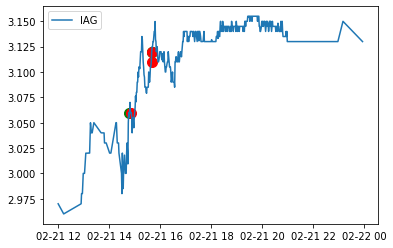

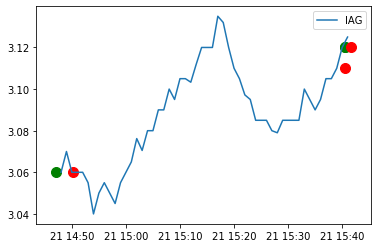

Delta = -0.010000000000000231


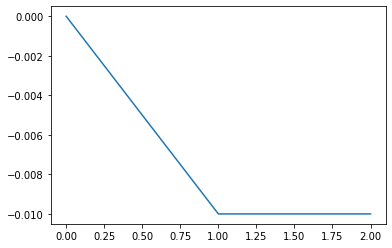

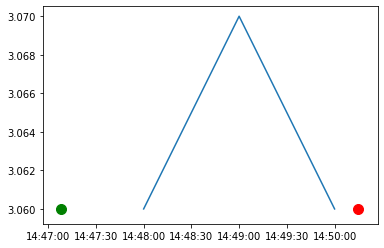

buy time:2020-02-21T14:47:08.087905614Z sell time:2020-02-21T14:50:14.550937382Z
{'rsi': 63.14148609630743, 'macd1': [0.021422289481451973, 0.02028905035519024, 0.022416694340538168, 0.024625911772471643, 0.0260761429596279], 'macd2': [0.010732576089368173, 0.011003357486850884, 0.01188582632557944, 0.012838652192277866, 0.013694748837821624], 'macd_signal': [0.01818085964196047, 0.018602497784606424, 0.019365337095792773, 0.020417452031128547, 0.02154919021682842]}
{'rsi': 60.67849891477378, 'macd': [0.015178592342462771, 0.01579828171174924, 0.01632533470454689, 0.017043488533940554, 0.01686226439406635], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.012713269409492004, 0.013330271869943452, 0.013929284436864139, 0.014552125256279422, 0.015014153083836808], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001848111310229543}


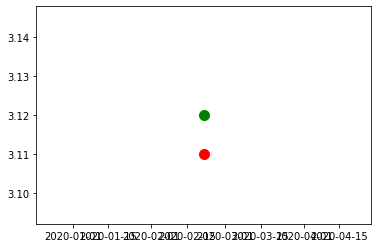

buy time:2020-02-21T15:40:27.974802339Z sell time:2020-02-21T15:40:30.70163873Z
{'rsi': 67.14182974640867, 'macd1': [0.0012743077131065483, 0.0022335015020553683, 0.002959553598786968, 0.00389353112643942, 0.005378629974298832], 'macd2': [0.015536999083398229, 0.015388352953840556, 0.015226982239755493, 0.015134130603582374, 0.01518443522683377], 'macd_signal': [0.002472064097070444, 0.002424351578067429, 0.0025313919822113366, 0.0028038198110569533, 0.003318781843705329]}
{'rsi': 64.82808825693067, 'macd': [1.041025782910765e-05, 0.0006887869742264741, 0.0012084469224031835, 0.0018574228960162031, 0.0025987363443378264], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016025641025640682, 'too_close': 0, 'macd_signal': [0.0005544654443323517, 0.0005813297503111761, 0.0007067531847295776, 0.0009368871269869027, 0.0012692569704570874], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0013294793738

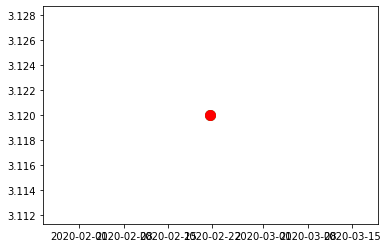

buy time:2020-02-21T15:40:32.195012485Z sell time:2020-02-21T15:41:39.595883445Z
{'rsi': 67.14182974640867, 'macd1': [0.0012743077131065483, 0.0022335015020553683, 0.002959553598786968, 0.00389353112643942, 0.005378629974298832], 'macd2': [0.015536999083398229, 0.015388352953840556, 0.015226982239755493, 0.015134130603582374, 0.01518443522683377], 'macd_signal': [0.002472064097070444, 0.002424351578067429, 0.0025313919822113366, 0.0028038198110569533, 0.003318781843705329]}
{'rsi': 67.14182974640867, 'macd': [1.041025782910765e-05, 0.0006887869742264741, 0.0012084469224031835, 0.0018574228960162031, 0.0028584766040777865], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0005544654443323517, 0.0005813297503111761, 0.0007067531847295776, 0.0009368871269869027, 0.0013212050224050795], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001537271581672707}
GORO analys

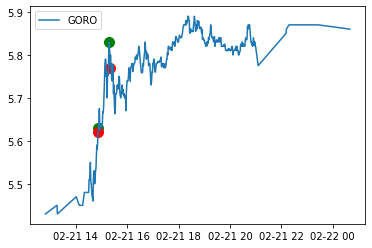

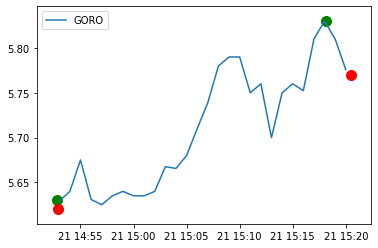

Delta = -0.07000000000000028


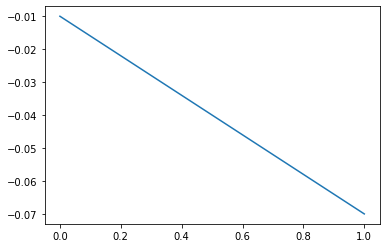

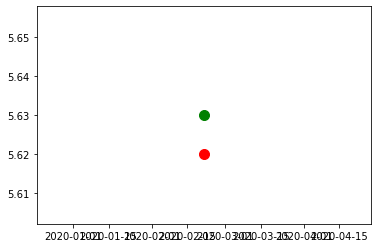

buy time:2020-02-21T14:52:44.449442685Z sell time:2020-02-21T14:52:50.877848692Z
{'rsi': 74.9824521933327, 'macd1': [0.04707723788828755, 0.04991750989567212, 0.050776212922588826, 0.052066920844844766, 0.055276826814192326], 'macd2': [0.021859546657056583, 0.023631725206149312, 0.025064454490690835, 0.026582428207511555, 0.02849627379310693], 'macd_signal': [0.045346389714621856, 0.04626061375083191, 0.04716373358518329, 0.04814437103711559, 0.049570862192530936]}
{'rsi': 73.94588008446024, 'macd': [0.028487747822452114, 0.03021216877156707, 0.03064402705955871, 0.031361786413063975, 0.032812484787054785], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017761989342806016, 'too_close': 0, 'macd_signal': [0.028005740812192488, 0.028447026404067405, 0.028886426535165665, 0.029381498510745327, 0.030067695766007218], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0027447890210475674}


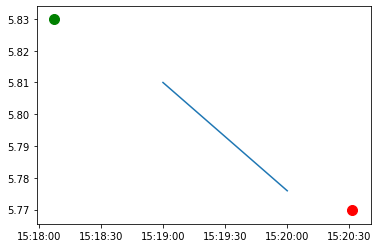

buy time:2020-02-21T15:18:07.311711115Z sell time:2020-02-21T15:20:31.402008101Z
{'rsi': 71.25598184999714, 'macd1': [0.05324472987520945, 0.052024114820198974, 0.04986865727202616, 0.05220647648901888, 0.05503859722610471], 'macd2': [0.051602209074248506, 0.0520807121783049, 0.052316103139409265, 0.05337022956441562, 0.0545745734211458], 'macd_signal': [0.0569118833622135, 0.055934329653810594, 0.054721195177453705, 0.05421825143976674, 0.054382320597034337]}
{'rsi': 58.871233450296444, 'macd': [0.02828070675798333, 0.029802856532548994, 0.031640858220099766, 0.03162318605169645, 0.02912080272499562], 'scalp': 0, 'bail_out': 0, 'movement': -0.011986301369863063, 'too_close': 1, 'macd_signal': [0.03159280599030976, 0.031234816098757605, 0.03131602452302604, 0.03137745682876012, 0.03092612600800722], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0018053232830116013}
AVEO analysis for run

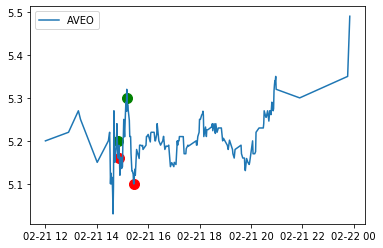

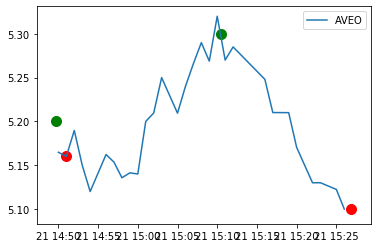

Delta = -0.2400000000000002


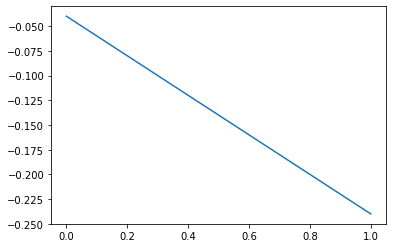

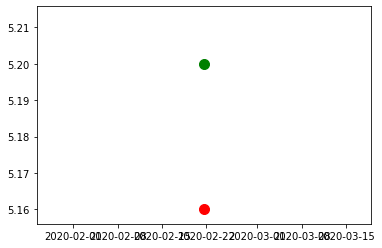

buy time:2020-02-21T14:49:45.573080997Z sell time:2020-02-21T14:50:56.717131446Z
{'rsi': 55.95253389864339, 'macd1': [0.00034327873106843043, -7.348736024770375e-05, 0.0006219065837100857, 0.0034012390858570996, 0.009448850144964993], 'macd2': [0.007810172018847261, 0.007564537052719089, 0.007531164719543071, 0.007937836291907807, 0.009082978212276771], 'macd_signal': [-0.0014054029029291104, -0.001139019794392829, -0.0007868345187722461, 5.0780202153622995e-05, 0.0019303941907158973]}
{'rsi': 49.94739025856075, 'macd': [-0.0002375974728101582, 0.0016223139197988345, 0.0055959810579384595, 0.004494994658333695, 0.0037968884422996396], 'scalp': 0, 'bail_out': 0, 'movement': -0.014351145038168053, 'too_close': 0, 'macd_signal': [-0.0013877850059940311, -0.0007857652208354579, 0.0004905840349193257, 0.0012914661596021997, 0.0017925506161416878], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0

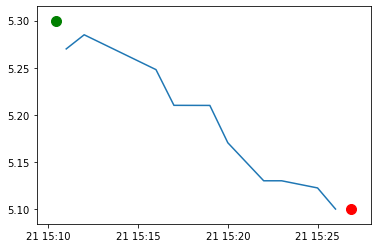

buy time:2020-02-21T15:10:26.535315735Z sell time:2020-02-21T15:26:53.446096865Z
{'rsi': 61.55905691929531, 'macd1': [0.015470329420775641, 0.020148374622613652, 0.025498428559977526, 0.027716294994550417, 0.03162697331229847], 'macd2': [0.009345283696881701, 0.01058416172716381, 0.012090887717076448, 0.013120321124481471, 0.014545449067680849], 'macd_signal': [0.006572941584656021, 0.009288028192247548, 0.012530108265793543, 0.015567345611544919, 0.01877927115169563]}
{'rsi': 37.7551499347285, 'macd': [0.007973046955215501, 0.0021644845142123614, -0.0023897782257140676, -0.006302323500648299, -0.010432848085003776], 'scalp': 0, 'bail_out': 0, 'movement': -0.006235385814497278, 'too_close': 1, 'macd_signal': [0.01386552615264931, 0.01152531782496192, 0.008742298614826723, 0.0057333741917317185, 0.002500129736384619], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.012932977821388395}
SOXS

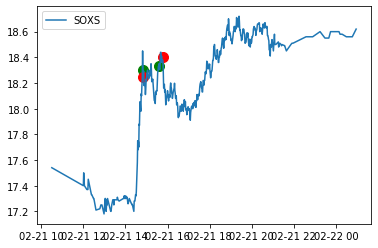

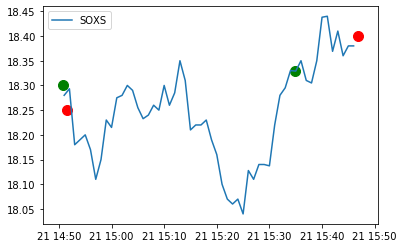

Delta = 0.019999999999999574


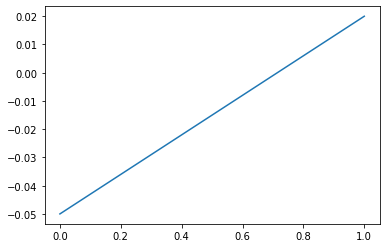

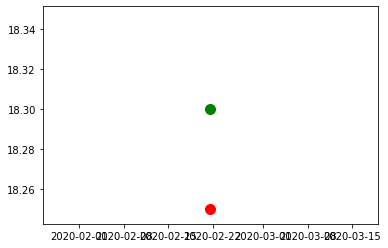

buy time:2020-02-21T14:50:44.350014729Z sell time:2020-02-21T14:51:28.929620374Z
{'rsi': 74.7811528392148, 'macd1': [0.2577929357955355, 0.2622622001941437, 0.2669231657463982, 0.28491539612783257, 0.2859450308012903], 'macd2': [0.12275712386618665, 0.12999433739721766, 0.13727656490034335, 0.14724189845695435, 0.15420601877680085], 'macd_signal': [0.22617044949682757, 0.2333887996362908, 0.2400956728583123, 0.24905961751221634, 0.2564367001700311]}
{'rsi': 69.59990829314184, 'macd': [0.1603233386119527, 0.1626122946219155, 0.17360352924497846, 0.16988756233768854, 0.16442723017178196], 'scalp': 0, 'bail_out': 0, 'movement': -0.004190584280943681, 'too_close': 0, 'macd_signal': [0.14451585836542616, 0.14813514561672403, 0.15322882234237492, 0.15656057034143764, 0.1581339023075065], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006293327864275444}


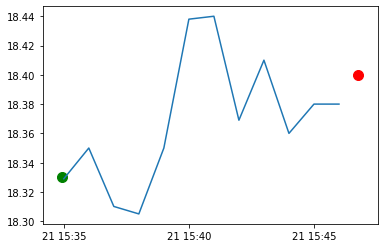

buy time:2020-02-21T15:34:56.765032627Z sell time:2020-02-21T15:46:44.811988738Z
{'rsi': 66.40689297201831, 'macd1': [-0.01303735108040982, -0.005198747491260036, 0.005796155577062478, 0.015556878430281529, 0.026193833618069817], 'macd2': [0.10492525772437844, 0.10336637467295162, 0.10272804784367295, 0.10221957034445239, 0.10222321488380715], 'macd_signal': [-0.0046366146259574775, -0.0047490411990179894, -0.002640001843801896, 0.0009993742110147893, 0.006038266092425795]}
{'rsi': 61.41104902290565, 'macd': [0.037671480034124016, 0.03872022885126114, 0.03643717300940352, 0.035223919457184394, 0.03486003461834741], 'scalp': 0, 'bail_out': 1, 'movement': 0.0035506056755148646, 'too_close': 0, 'macd_signal': [0.02652036447282573, 0.02896033734851281, 0.030455704480690952, 0.03140934747598964, 0.0320994849044612], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002760549713886215}
LAKE analys

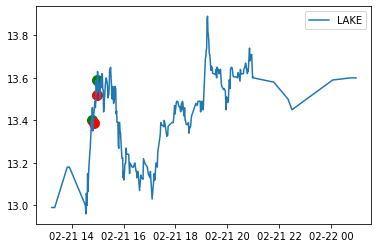

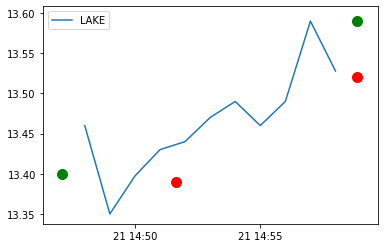

Delta = -0.08000000000000007


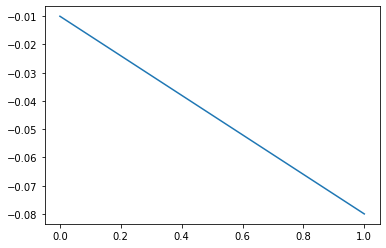

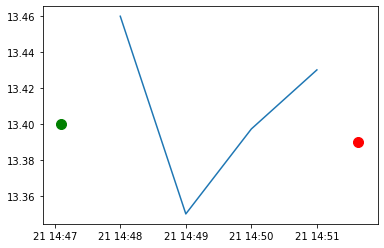

buy time:2020-02-21T14:47:05.869496586Z sell time:2020-02-21T14:51:37.653428006Z
{'rsi': 74.6690989624314, 'macd1': [0.10996192912135605, 0.11710861673093476, 0.12536190626287436, 0.13357446180769372, 0.13850253852448802], 'macd2': [0.04608346563659893, 0.05027651120768972, 0.05485351713102027, 0.05961332383276208, 0.06390035379092929], 'macd_signal': [0.08304558632848184, 0.08985819240897243, 0.09695893517975282, 0.104282040505341, 0.11112614010917041]}
{'rsi': 65.02845968366591, 'macd': [0.08348875313637194, 0.08817468310928511, 0.08497703525558897, 0.08383371179484556, 0.08152159336056641], 'scalp': 0, 'bail_out': 1, 'movement': 0.0030561797752809614, 'too_close': 0, 'macd_signal': [0.06897399211457374, 0.07281413031351601, 0.0752467113019306, 0.0769641114005136, 0.07787560779252416], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0036459855680422565}


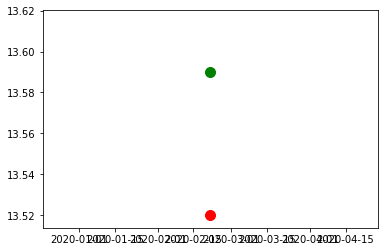

buy time:2020-02-21T14:58:50.815416777Z sell time:2020-02-21T14:58:52.508099787Z
{'rsi': 73.09770545328182, 'macd1': [0.13761521199921312, 0.13387903005149404, 0.1318192974138057, 0.1366805405334084, 0.1389315937976736], 'macd2': [0.08600255297440818, 0.08817716065239978, 0.09051665030631817, 0.0941236471445599, 0.0972916619931059], 'macd_signal': [0.1321192560107594, 0.13247121081890634, 0.13234082813788622, 0.13320877061699066, 0.13435333525312726]}
{'rsi': 66.04728022803307, 'macd': [0.08252086509218515, 0.07978809211882876, 0.0781808912029831, 0.0811079957983889, 0.07890693449872543], 'scalp': 0, 'bail_out': 0, 'movement': -0.004856512141280407, 'too_close': 1, 'macd_signal': [0.08040492661096688, 0.08028155971253925, 0.07986142601062803, 0.0801107399681802, 0.07986997887428925], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0009630443755638124}
HMY analysis for run 69
2020-02-21T15

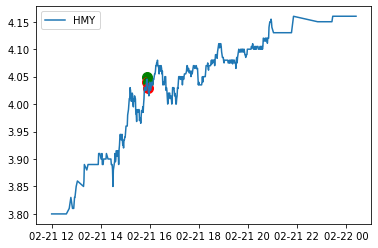

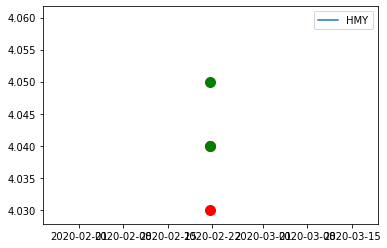

Delta = -0.019999999999999574


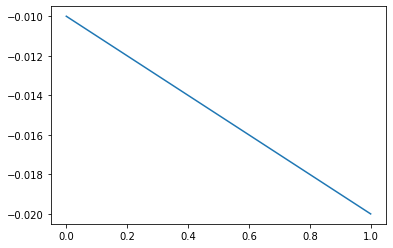

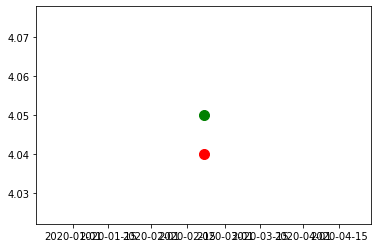

buy time:2020-02-21T15:54:14.876373361Z sell time:2020-02-21T15:54:18.508066369Z
{'rsi': 71.3090168642458, 'macd1': [0.010748979596884478, 0.01122810766980109, 0.012672118465735238, 0.014057914747841238, 0.015382308817891932], 'macd2': [0.021515954301928097, 0.021409076398513083, 0.021516408521123243, 0.021660713031335543, 0.02183880252588688], 'macd_signal': [0.0059018432084150755, 0.006967096100692278, 0.00810810057370087, 0.009298063408528944, 0.010514912490401542]}
{'rsi': 69.85146320441096, 'macd': [0.006468767835922762, 0.006773343369663287, 0.007701930235310073, 0.008585219608082895, 0.0091620006828661], 'scalp': 0, 'bail_out': 0, 'movement': -0.0012345679012345416, 'too_close': 0, 'macd_signal': [0.0031725521042483195, 0.003892710357331313, 0.004654554332927065, 0.005440687387958231, 0.006184950046939805], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0029770506359262953}


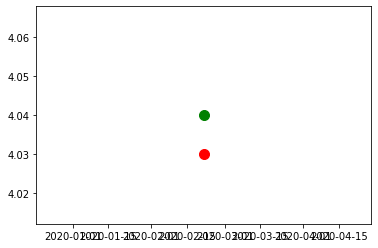

buy time:2020-02-21T15:55:30.603185865Z sell time:2020-02-21T15:55:31.883393994Z
{'rsi': 69.85146320441096, 'macd1': [0.01122810766980109, 0.012672118465735238, 0.014057914747841238, 0.014983448419030765, 0.015537830088264926], 'macd2': [0.021409076398513083, 0.021516408521123243, 0.021660713031335543, 0.02175883451309213, 0.02181430919980487], 'macd_signal': [0.006967096100692278, 0.00810810057370087, 0.009298063408528944, 0.010435140410629307, 0.01145567834615643]}
{'rsi': 62.962186868467086, 'macd': [0.006773343369663287, 0.007701930235310073, 0.008585219608082895, 0.0091620006828661, 0.00897297294006183], 'scalp': 0, 'bail_out': 0, 'movement': -0.0024721878862793045, 'too_close': 0, 'macd_signal': [0.003892710357331313, 0.004654554332927065, 0.005440687387958231, 0.006184950046939805, 0.00674255462556421], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0022304183144976194}
VNTR analys

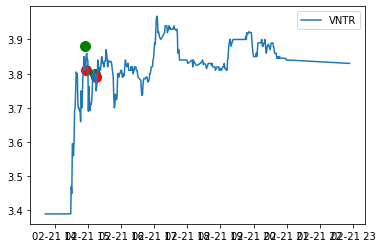

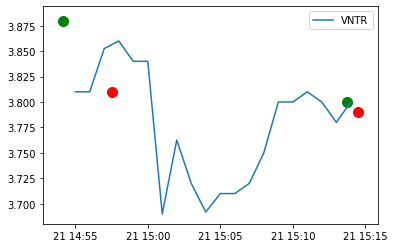

Delta = -0.07999999999999963


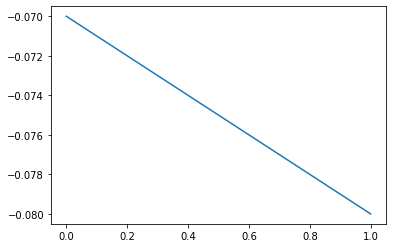

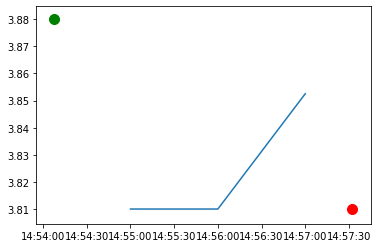

buy time:2020-02-21T14:54:07.754226813Z sell time:2020-02-21T14:57:31.93500855Z
{'rsi': 73.09070963423576, 'macd1': [0.06182793779952789, 0.06452354254810055, 0.06749561415968186, 0.07224586269685052, 0.07753741510976742], 'macd2': [0.04574791319147398, 0.047483898007941505, 0.049324987760304584, 0.05157970490110664, 0.05405143033948345], 'macd_signal': [0.07061074337805816, 0.06939330321206663, 0.06901376540158968, 0.06966018486064185, 0.07123563091046696]}
{'rsi': 64.7613778594356, 'macd': [0.04251893032660403, 0.04378854926912101, 0.04265073871434044, 0.041210227389649745, 0.039552553274440516], 'scalp': 0, 'bail_out': 0, 'movement': -0.00781249999999995, 'too_close': 1, 'macd_signal': [0.04141405351763136, 0.04188895266792929, 0.04204130987721152, 0.04187509337969916, 0.04141058535864743], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0018580320842069148}


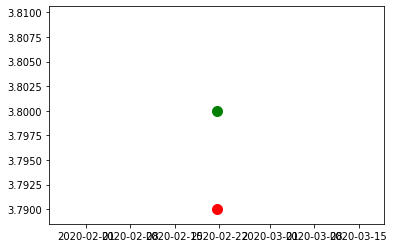

buy time:2020-02-21T15:13:43.689018034Z sell time:2020-02-21T15:14:27.774957687Z
{'rsi': 60.43449373995939, 'macd1': [0.016268815019814475, 0.018777733040715727, 0.021327139090815184, 0.022283771875470926, 0.025108669107033688], 'macd2': [0.04938772098180788, 0.049354385299115844, 0.049404715988011993, 0.0492120698669396, 0.049423134639408506], 'macd_signal': [0.027627663018713354, 0.02585767702311383, 0.0249515694366541, 0.024418009924417467, 0.02455614176094071]}
{'rsi': 55.651188020898424, 'macd': [0.006507979866435143, 0.008321717638073434, 0.010146426062231928, 0.010917024495833427, 0.010856230749343165], 'scalp': 0, 'bail_out': 0, 'movement': -0.010237125248093629, 'too_close': 0, 'macd_signal': [0.013434069555976392, 0.0124115991723958, 0.011958564550363026, 0.011750256539457106, 0.011571451381434318], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007152206320911528}
TECS analys

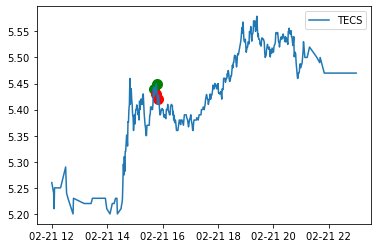

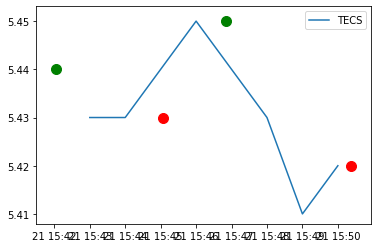

Delta = -0.040000000000000924


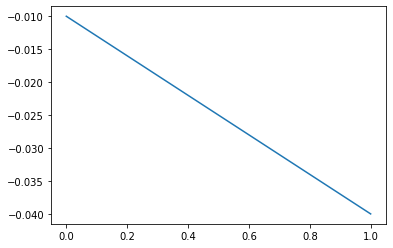

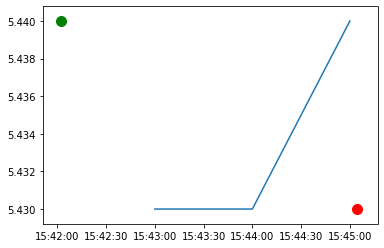

buy time:2020-02-21T15:42:02.374406013Z sell time:2020-02-21T15:45:04.681556274Z
{'rsi': 69.43614137639696, 'macd1': [0.0026211744892359334, 0.0033544414464703465, 0.004688431895056411, 0.008073314076767701, 0.010904508788060596], 'macd2': [0.019584568806695124, 0.019302752072086093, 0.01917253563281296, 0.01950187662869407, 0.019828068601908555], 'macd_signal': [-0.0006512355944052435, 0.00014989981376987462, 0.0010576062300271818, 0.0024607477993752857, 0.004149499997112348]}
{'rsi': 61.80782220305012, 'macd': [0.00665881311851102, 0.007057601325488605, 0.007536428482541879, 0.00781166485839524, 0.007924684568691553], 'scalp': 0, 'bail_out': 0, 'movement': -0.0024616967336590838, 'too_close': 0, 'macd_signal': [0.0020740046147620424, 0.003070723956907355, 0.00396386486203426, 0.004733424861306456, 0.005371676802783476], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0025530077659080778}

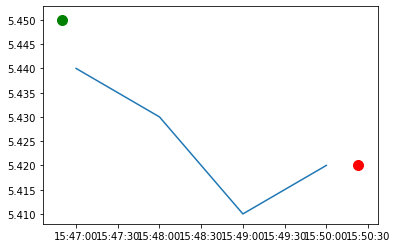

buy time:2020-02-21T15:46:49.98145743Z sell time:2020-02-21T15:50:22.792982534Z
{'rsi': 67.57280346621282, 'macd1': [0.01153060710844045, 0.012288597449382266, 0.012742423529044977, 0.013750493266340591, 0.015181311513323692], 'macd2': [0.01980218113927723, 0.019826661036889348, 0.01981747335206574, 0.019937261134479023, 0.020175518888494892], 'macd_signal': [0.005625721419377968, 0.006958296625378828, 0.008115122006112058, 0.009242196258157764, 0.01043001930919095]}
{'rsi': 55.99510000075657, 'macd': [0.009346838447891415, 0.009409352254842851, 0.00881638441279442, 0.007200872011031478, 0.006877084788736276], 'scalp': 0, 'bail_out': 0, 'movement': -3.683241252293442e-05, 'too_close': 1, 'macd_signal': [0.00624982601492185, 0.0068817312629060505, 0.0072686618928837245, 0.007255103916513276, 0.007179500090957876], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00030241530222159963}
DWT an

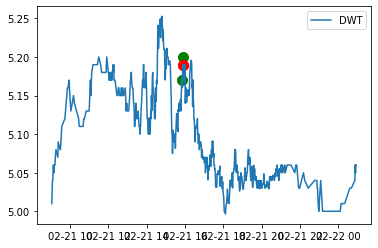

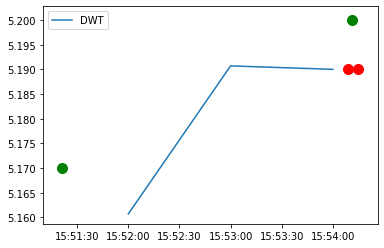

Delta = 0.010000000000000675


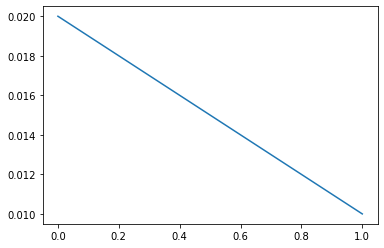

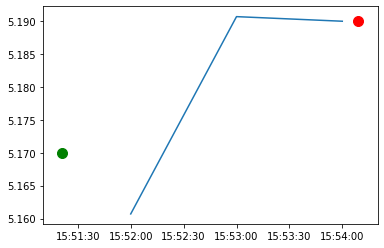

buy time:2020-02-21T15:51:20.814179458Z sell time:2020-02-21T15:54:08.833149518Z
{'rsi': 64.4501873474745, 'macd1': [0.002276759839474174, 0.00210077516507301, 0.003534396572137055, 0.005167753554056631, 0.00783243206064288], 'macd2': [0.004999285015307109, 0.004835205312839541, 0.004996385554091098, 0.00524704136892673, 0.005758745033245916], 'macd_signal': [-0.0033547328126330373, -0.0022636312170918275, -0.001104025659246051, 0.00015033018341448537, 0.0016867505588601644]}
{'rsi': 67.57268178724598, 'macd': [0.005556194153315985, 0.006546705047284718, 0.006750392691322382, 0.008379884456918951, 0.009862866554047223], 'scalp': 0, 'bail_out': 1, 'movement': 0.004231884057971106, 'too_close': 0, 'macd_signal': [0.0017902844351464862, 0.0027415685575741325, 0.0035433333843237825, 0.004510643598842816, 0.005581088189883698], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004281778364163525}

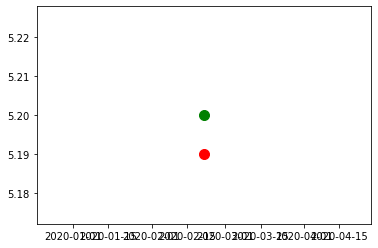

buy time:2020-02-21T15:54:11.180795498Z sell time:2020-02-21T15:54:14.548252428Z
{'rsi': 68.21541046784006, 'macd1': [0.007696819525030207, 0.009327320561832941, 0.009756604045802142, 0.01237491328200857, 0.01502715085132067], 'macd2': [0.0057315559088948476, 0.0061153790727619395, 0.006309987462913114, 0.00695874954043596, 0.00769324236019564], 'macd_signal': [0.0016596280517376298, 0.0031931665537566923, 0.004505854052165782, 0.00607966589813434, 0.007869162888771606]}
{'rsi': 67.99028248533257, 'macd': [0.005556194153315985, 0.006546705047284718, 0.006750392691322382, 0.008379884456918951, 0.009966762657943384], 'scalp': 0, 'bail_out': 0, 'movement': -0.00021153846153848093, 'too_close': 0, 'macd_signal': [0.0017902844351464862, 0.0027415685575741325, 0.0035433333843237825, 0.004510643598842816, 0.00560186741066293], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0043648952472804545}
S

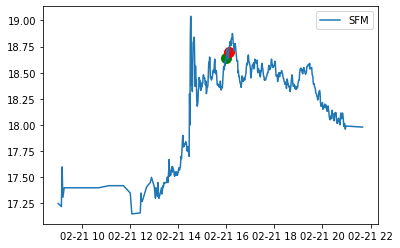

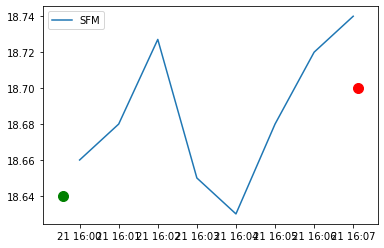

Delta = 0.05999999999999872


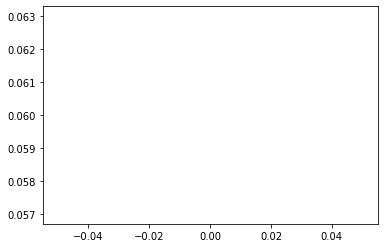

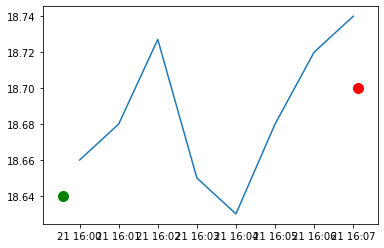

buy time:2020-02-21T15:59:33.792929397Z sell time:2020-02-21T16:07:06.685239866Z
{'rsi': 66.19717776860209, 'macd1': [0.01709982626463713, 0.027467779424149796, 0.03248577372947281, 0.03844020489484734, 0.046169286806239995], 'macd2': [0.10161015125848394, 0.10134245974018086, 0.10037431578873068, 0.09980286577056319, 0.0998196118901582], 'macd_signal': [-0.004258585429074311, 0.002086687541570511, 0.008166504779150971, 0.014221244802290246, 0.020610853203080197]}
{'rsi': 63.140471488202664, 'macd': [0.04173166932628547, 0.03973175821249697, 0.04025479165353829, 0.042217482754953295, 0.0421596124085859], 'scalp': 0, 'bail_out': 1, 'movement': 0.003009027081243769, 'too_close': 0, 'macd_signal': [0.02826924402989775, 0.030561746866417595, 0.03250035582384173, 0.03444378121006404, 0.035986947449768415], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006172664958817485}
UVXY analysis for run

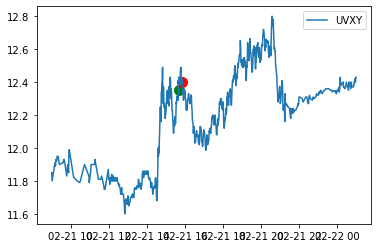

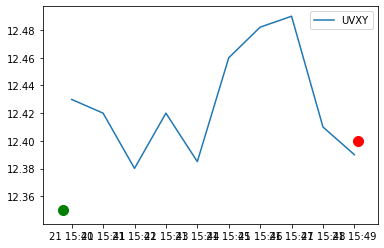

Delta = 0.05000000000000071


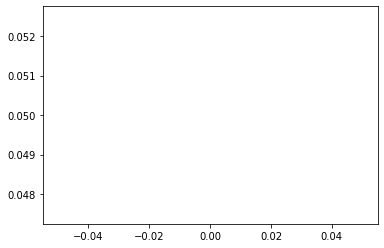

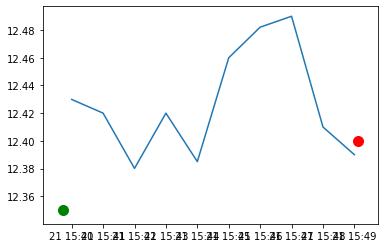

buy time:2020-02-21T15:39:42.813558139Z sell time:2020-02-21T15:49:06.034151065Z
{'rsi': 60.99345770067165, 'macd1': [0.0067385638466692654, 0.012917081279576692, 0.016812876062855864, 0.018078095610292166, 0.024447391886942782], 'macd2': [0.06821166560095371, 0.06784556609691705, 0.06724029731515913, 0.06625601716478613, 0.06636403288063342], 'macd_signal': [-0.008268179365003748, -0.00403112723608766, 0.00013767342370104522, 0.00372575786101927, 0.007870084666203973]}
{'rsi': 55.58506135784832, 'macd': [0.03244926907234813, 0.03584895042888547, 0.03844287161022919, 0.03580900666568887, 0.03277211181714179], 'scalp': 0, 'bail_out': 1, 'movement': 0.0032362459546926314, 'too_close': 0, 'macd_signal': [0.021777067380566673, 0.024591443990230433, 0.027361729514230184, 0.02905118494452192, 0.029795370319045895], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002976741498095896}
BXRX analysis

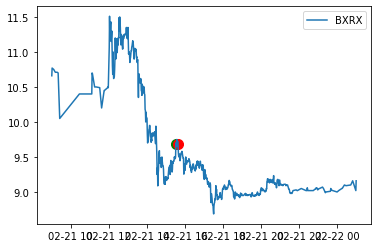

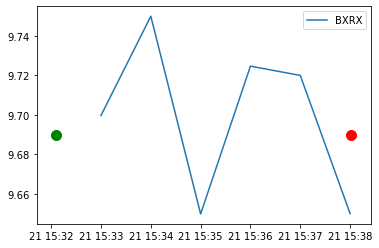

Delta = 0.0


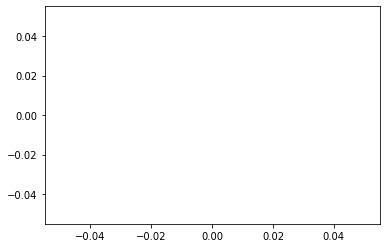

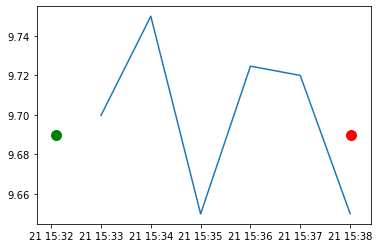

buy time:2020-02-21T15:32:05.67339321Z sell time:2020-02-21T15:38:01.413194053Z
{'rsi': 71.2810862713001, 'macd1': [0.06557592538675827, 0.06421735831929176, 0.06441543416877771, 0.07979893594066745, 0.09093417025265182], 'macd2': [0.14513006121331706, 0.14345065257484535, 0.14207595369942538, 0.14378427599964816, 0.14512442494359767], 'macd_signal': [0.05913987017578913, 0.06015536780448966, 0.06100738107734727, 0.0647656920500113, 0.0699993876905394]}
{'rsi': 58.75768008818406, 'macd': [0.06308902680469863, 0.06181384617685204, 0.06390833080220659, 0.06446626257777943, 0.06042742678500623], 'scalp': 0, 'bail_out': 0, 'movement': -0.005154639175257623, 'too_close': 0, 'macd_signal': [0.046824728558769235, 0.0498225520823858, 0.052639707826349955, 0.05500501877663585, 0.056089500378309926], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0043379264066963075}
CRC analysis for run 69
2020-02

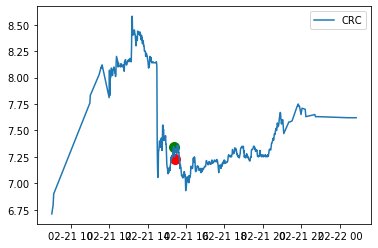

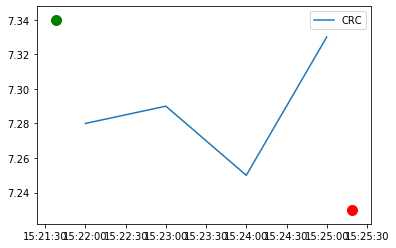

Delta = -0.10999999999999943


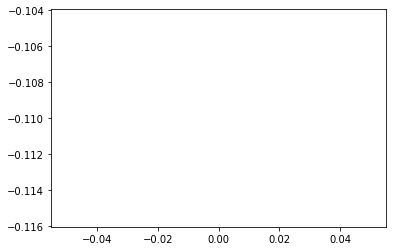

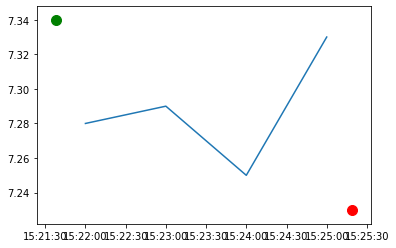

buy time:2020-02-21T15:21:37.863223919Z sell time:2020-02-21T15:25:18.587239384Z
{'rsi': 58.80012722536725, 'macd1': [-0.0021079460641324488, 0.0017664920797466621, 0.00797277276706243, 0.012744385581716422, 0.019528476697679764], 'macd2': [0.07036267098464499, 0.0692375423883167, 0.06873139641882275, 0.06815579967292873, 0.0681569706801275], 'macd_signal': [-0.01272725101450711, -0.009828502395656354, -0.006268247363112597, -0.002465720774146793, 0.0019331187202185187]}
{'rsi': 45.74133058650675, 'macd': [0.011537300561828445, 0.011700736520359634, 0.012195612117651855, 0.010344922815312074, 0.007989256828874858], 'scalp': 0, 'bail_out': 0, 'movement': -0.0075445816186556535, 'too_close': 0, 'macd_signal': [-0.0014911580797080087, 0.00114722084030552, 0.003356899095774787, 0.004754503839682244, 0.005401454437520767], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002587802391354091}
AMSW

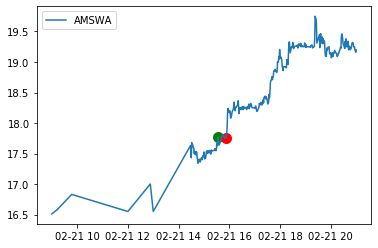

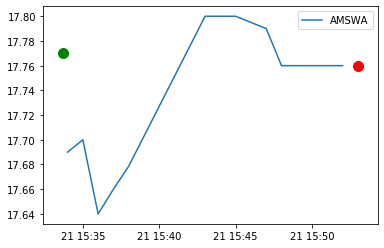

Delta = -0.00999999999999801


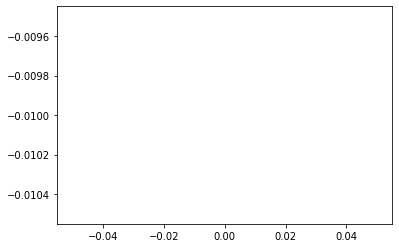

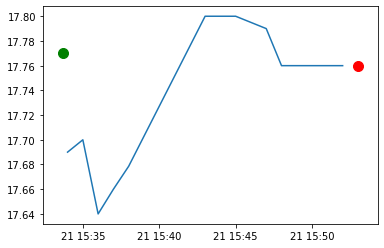

buy time:2020-02-21T15:33:40.859255722Z sell time:2020-02-21T15:52:59.710938034Z
{'rsi': 73.04740113892198, 'macd1': [0.03900985024504422, 0.042025966569209317, 0.04758758515288264, 0.04852289788763642, 0.059870816436092156], 'macd2': [0.15830678416980604, 0.15627997373728064, 0.1549026004065368, 0.1528102587689233, 0.15287994323784915], 'macd_signal': [0.04910526910866754, 0.0476894086007759, 0.047669043911197244, 0.04783981470648508, 0.050246015052406494]}
{'rsi': 62.574600820909474, 'macd': [0.041051851484599666, 0.04003793113583143, 0.03872789019996148, 0.03720411946811453, 0.03553359526839017], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.03596685590733063, 0.03678107095303079, 0.03717043480241693, 0.037177171735556444, 0.03684845644212319], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0013148611737330146}
OILD analysis for run 69
2020-02-21T15:48:

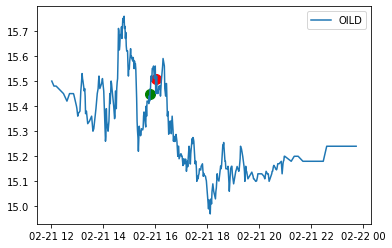

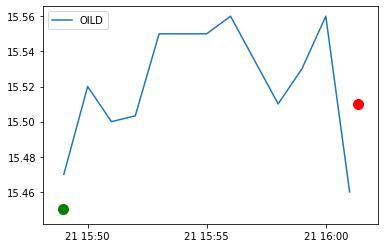

Delta = 0.0600000000000005


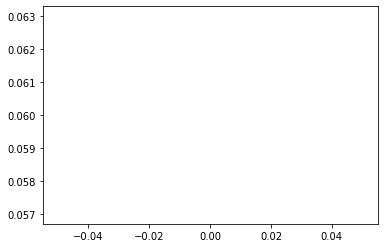

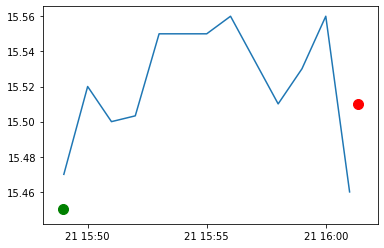

buy time:2020-02-21T15:48:57.545260837Z sell time:2020-02-21T16:01:20.532534114Z
{'rsi': 57.29420582023859, 'macd1': [-0.01197128618708021, -0.00777406524414026, -0.0019241164683982959, 0.0010058903099565697, 0.005683178921943366], 'macd2': [0.02297427796895768, 0.022527776886986928, 0.022576753257574467, 0.02224983906952538, 0.022393290127910248], 'macd_signal': [-0.031006022926399528, -0.026359631389947673, -0.0214725284056378, -0.016976844662518926, -0.012444839945626469]}
{'rsi': 55.494873515292895, 'macd': [0.027539814111127825, 0.026294499831914564, 0.026021599097049375, 0.02702425308160805, 0.024862369782800542], 'scalp': 0, 'bail_out': 1, 'movement': 0.0038899676375404703, 'too_close': 0, 'macd_signal': [0.016126673583739943, 0.018160238833374868, 0.01973251088610977, 0.021190859325209428, 0.02192516141672765], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002937208366072891}
EDA

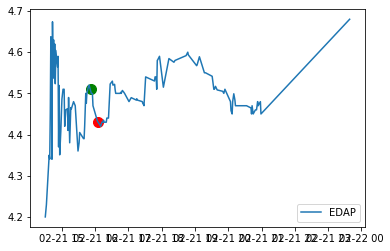

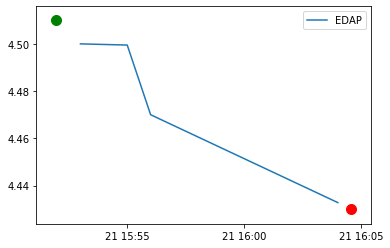

Delta = -0.08000000000000007


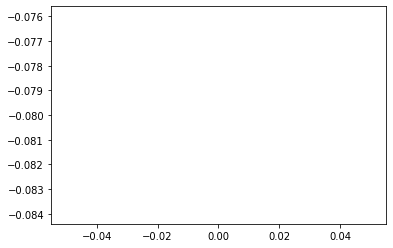

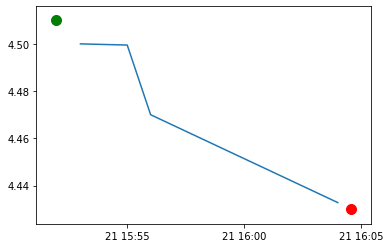

buy time:2020-02-21T15:51:56.729010729Z sell time:2020-02-21T16:04:34.372906741Z
{'rsi': 56.107217188872184, 'macd1': [-0.0014508677971489803, 0.0021818493322456334, 0.0069176607660184075, 0.01194523199457631, 0.015947514501343463], 'macd2': [0.03846722702066252, 0.038191566931027765, 0.03826071521812402, 0.03854302923161246, 0.038781106971760515], 'macd_signal': [0.0004441320040412977, 0.0007916754696821648, 0.002016872528949413, 0.004002544422074793, 0.006391538437928527]}
{'rsi': 47.583447934464, 'macd': [0.008806389062169906, 0.009751290036299487, 0.010334962353332422, 0.009123084128249026, 0.006127814288856115], 'scalp': 0, 'bail_out': 0, 'movement': -0.008322147651006591, 'too_close': 1, 'macd_signal': [0.00196943593558728, 0.0035258067557297212, 0.004887637875250261, 0.005734727125850015, 0.005813344558451235], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0003144697304048802}


In [14]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)


        for trade in trade_details[run_id][symbol]:
            print(trade[0], trade[1])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)

        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
        for trade in trade_details[run_id][symbol]:
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])
